In [17]:
import pandas as pd
import os
import json
import pandas as pd
from collections import defaultdict

In [18]:
json_path = "Final_QA_JSON_filtered_0723.JSON"
with open(json_path, "r", encoding="utf-8") as f:
    QASet = json.load(f)

In [22]:
# === Get model folders in current directory ===
model_folders = [
    d for d in os.listdir()
    if os.path.isdir(d) and not d.startswith('.') and "checkpoint" not in d.lower()
]

# === Find events with full coverage across all models ===
event_to_models = defaultdict(list)
for model in model_folders:
    for file in os.listdir(model):
        if file.endswith(".csv") and file.startswith("EvtID"):
            event_name = file.replace(".csv", "")
            event_to_models[event_name].append(model)

# Keep only events that exist in ALL model folders
valid_events = [evt for evt, models in event_to_models.items() if len(models) == len(model_folders)]

print(f"✔ Found {len(valid_events)} fully-covered events across all {len(model_folders)} models.")

# === Merge data ===
all_rows = []

for event_file_prefix in valid_events:
    event_id = event_file_prefix.split("_")[0]               # e.g., EvtID00
    event_name = event_file_prefix.replace(f"{event_id}_", "")  # match JSON key

    if event_name not in QASet:
        print(f"⚠ Skipping: {event_name} not found in QASet.")
        continue

    qa_list = QASet[event_name]["qa"]

    # Load responses from each model
    model_responses = {}
    for model in model_folders:
        file_path = os.path.join(model, f"{event_file_prefix}.csv")
        df = pd.read_csv(file_path)
        model_responses[model] = df['response'].tolist()

    for q_idx, qa in enumerate(qa_list):
        # Parse question_type list
        qtype_list = qa.get("question_type", [])
        question_id = qtype_list[0] if len(qtype_list) > 0 else ""
        question_stage = qtype_list[1] if len(qtype_list) > 1 else ""
        question_type = qtype_list[-1] if len(qtype_list) > 0 else ""
        question_ability = qtype_list[2:-1] if len(qtype_list) > 3 else []

        row = {
            "EventID": event_id,
            "EventName": event_name,
            "Question_ID": question_id,
            "Question_Stage": question_stage,
            "Question_Type": question_type,
            "Question_Ability": ", ".join(question_ability),
            "Context": qa.get("context", ""),
            "Question_Text": qa.get("question", ""),
            "Answer_Ground_Truth": qa.get("answer", "")
        }

        for model in model_folders:
            row[f"Answer_{model}"] = model_responses[model][q_idx] if q_idx < len(model_responses[model]) else ""

        all_rows.append(row)

# === Save final CSV ===
merged_df = pd.DataFrame(all_rows)
output_file = "Merged_Evaluation.csv"
merged_df.to_csv(output_file, index=False)
print(f"\n✅ Merged evaluation saved to: {output_file}")

✔ Found 272 fully-covered events across all 14 models.

✅ Merged evaluation saved to: Merged_Evaluation.csv


In [26]:
from pathlib import Path
import re

# ------------------------------------------------------------------
# 1) collect valid files and grab their numeric IDs with a regex
# ------------------------------------------------------------------
id_pattern = re.compile(r'^EvtID(\d+)_')      # captures the number
valid_files = []                              # (old_id, Path) pairs

for model in model_folders:
    for fp in Path(model).glob('EvtID*.csv'):
        m = id_pattern.match(fp.name)
        if not m:
            continue                          # skip weird names
        old_id = int(m.group(1))
        if (0 <= old_id <= 149) or (350 <= old_id <= 471):
            valid_files.append((old_id, fp))

if not valid_files:
    print('⚠ No files in the two target ranges – nothing to rename.')
else:
    # ------------------------------------------------------------------
    # 2) build a gap-free new numbering: first block, then second block
    # ------------------------------------------------------------------
    first  = [id for id, _ in valid_files if id < 150]
    second = [id for id, _ in valid_files if id >= 350]
    id_map = {old: new for new, old in enumerate(sorted(first) + sorted(second), start=1)}

    # ------------------------------------------------------------------
    # 3) two-step rename inside each model folder (tmp → final)
    # ------------------------------------------------------------------
    for old_id, fp in valid_files:
        tmp = fp.with_suffix(fp.suffix + '.tmp')   # collision-free
        fp.rename(tmp)

    for old_id, fp_tmp in valid_files:
        fp_tmp = fp_tmp.with_suffix(fp_tmp.suffix + '.tmp')  # same Path object
        new_id = id_map[old_id]
        rest   = '_'.join(fp_tmp.name.split('_')[1:])         # everything after first “_”
        final  = fp_tmp.with_name(f'{new_id}_{rest[:-4]}')    # strip ".tmp" before ".csv"
        fp_tmp.rename(final)

    print('✅ All event files renamed; proceeding to merge …')

✅ All event files renamed; proceeding to merge …


In [4]:
# Extract valid numeric IDs
valid_ids = {int(e.split('_')[0].replace('EvtID', '')) for e in valid_events}

# Define target ranges
range1 = range(0, 150)
range2 = range(350, 472)

# Find missing IDs
missing_ids = sorted([i for i in list(range1) + list(range2) if i not in valid_ids])

# Print
print("❌ Event IDs not valid in [0–149] and [350–471]:")
print(missing_ids)

❌ Event IDs not valid in [0–149] and [350–471]:
[]


In [5]:
# Make a copy to avoid modifying original
clean_df = merged_df.copy()

# Remove newlines and carriage returns from all string columns
for col in clean_df.columns:
    if clean_df[col].dtype == object:
        clean_df[col] = clean_df[col].astype(str).str.replace(r'[\r\n]+', ' ', regex=True).str.strip()

# Save clean version
clean_df.to_csv("Merged_Evaluation_Clean.csv", index=False)
print("✅ Clean CSV saved without embedded newlines.")

✅ Clean CSV saved without embedded newlines.


In [15]:
# Filter TF-type questions
tf_df = merged_df[merged_df['Question_Type'] == 'TF'].copy()

# Standardize ground truth
tf_df['Answer_Ground_Truth_Upper'] = tf_df['Answer_Ground_Truth'].astype(str).str.upper().str.strip()

# Prepare results
model_accuracies = {}
model_hallucination_rates = {}

# Acceptable answers (can customize)
valid_tf_answers = ['YES', 'NO']

for model in model_folders:
    col = f"Answer_{model}"
    upper_col = f"{col}_Upper"

    # Standardize model response
    tf_df[upper_col] = tf_df[col].astype(str).str.upper().str.strip()

    # Acceptable keywords (case-insensitive inclusion)
    valid_tf_keywords = ['YES', 'NO']

    # Check if response contains either 'YES' or 'NO'
    is_valid_tf = tf_df[upper_col].apply(lambda x: any(keyword in x for keyword in valid_tf_keywords))

    # Mark hallucinations
    is_hallucinated = ~is_valid_tf

    # Filter out hallucinated rows
    eval_df = tf_df

    # Calculate accuracy
    correct = tf_df.apply(
        lambda row: row[upper_col] in row['Answer_Ground_Truth_Upper'] or 
                    row['Answer_Ground_Truth_Upper'] in row[upper_col], axis=1
    ).sum()
    total_valid = len(eval_df)
    acc = correct / total_valid if total_valid > 0 else float('nan')
    model_accuracies[model] = acc

    # Calculate hallucination rate
    hallucination_rate = is_hallucinated.sum() / len(tf_df)
    model_hallucination_rates[model] = hallucination_rate

# Convert to DataFrame
accuracy_df = pd.DataFrame({
    "Accuracy (Excl. Hallucinations)": model_accuracies,
    "Hallucination Rate": model_hallucination_rates
}).sort_values(by="Accuracy (Excl. Hallucinations)", ascending=False)

In [16]:
accuracy_df

,Accuracy (Excl. Hallucinations),Hallucination Rate
gpt-4o,0.821212,0.000000
gemini-2.5-flash-lite,0.778512,0.000275
mistral-small3.1_24b,0.735813,0.000000
llama3_latest,0.649311,0.000551
qwen2.5vl_7b,0.568320,0.000000
llava,0.506336,0.000000
gemma3_12b,0.499725,0.252893


In [17]:
# Filter MC-type and AUTO-type questions
mc_df = merged_df[(merged_df['Question_Type'] == 'MC') | (merged_df['Question_Type'] == 'AUTO')].copy()

# Function to extract the first alphabetical character (A–Z or a–z)
def extract_first_letter(text):
    text = str(text).strip()
    for char in text:
        if char.isalpha():
            return char.upper()
    return ""

# Extract ground truth letter
mc_df['GT_Letter'] = mc_df['Answer_Ground_Truth'].apply(extract_first_letter)

# Initialize accuracy and hallucination tracking
model_accuracies = {}
model_hallucination_rates = {}

for model in model_folders:
    col = f"Answer_{model}"
    letter_col = f"{col}_Letter"

    # Extract first letter from response
    mc_df[letter_col] = mc_df[col].apply(extract_first_letter)

    # Count correct answers (compared to GT)
    correct = (mc_df[letter_col] == mc_df['GT_Letter']).sum()
    total = len(mc_df)
    acc = correct / total if total > 0 else 0

    # Hallucinated = response contains no alphabetic letter
    valid_choices = {'A', 'B', 'C', 'D','E'}
    hallucinated = ~mc_df[col].astype(str).str.strip().str.upper().str.startswith(('A', 'B', 'C', 'D'))

    hallucination_rate = hallucinated.sum() / total if total > 0 else 0
    # Save results
    model_accuracies[model] = acc
    model_hallucination_rates[model] = hallucination_rate

# Combine into single DataFrame
accuracy_df = pd.DataFrame({
    "Accuracy": model_accuracies,
    "Hallucination Rate": model_hallucination_rates
}).sort_values(by="Accuracy", ascending=False)

In [18]:
accuracy_df

,Accuracy,Hallucination Rate
gemini-2.5-flash-lite,0.549714,0.023766
gpt-4o,0.547573,0.019861
qwen2.5vl_7b,0.513646,0.023514
mistral-small3.1_24b,0.473967,0.105097
llama3_latest,0.348757,0.073312
gemma3_12b,0.296355,0.289259
llava,0.271582,0.016753


In [19]:
# === Helper ===
def extract_first_letter(text):
    """Extracts the first alphabetical letter (A-Z or a-z)"""
    text = str(text).strip()
    for char in text:
        if char.isalpha():
            return char.upper()
    return ""

# === MC/AUTO Evaluation ===
def evaluate_mc_auto_accuracy(df, model_folders, ability_filter=None):
    
    
    mc_df = df[df['Question_Type'].isin(['MC', 'AUTO'])].copy()
    # Optional ability filter like 'SA'
    if ability_filter:
        mc_df = mc_df[mc_df['Question_Ability'].str.contains(rf'\b{ability_filter}\b', na=False)]
    
    mc_df['GT_Letter'] = mc_df['Answer_Ground_Truth'].apply(extract_first_letter)

    accuracies = {}
    hallucinations = {}

    for model in model_folders:
        col = f"Answer_{model}"
        letter_col = f"{col}_Letter"

        mc_df[letter_col] = mc_df[col].apply(extract_first_letter)
        correct = (mc_df[letter_col] == mc_df['GT_Letter']).sum()
        total = len(mc_df)
        acc = correct / total if total > 0 else 0

        # Hallucination: response does not begin with A–E
        hallucinated = ~mc_df[col].astype(str).str.strip().str.upper().str.startswith(('A', 'B', 'C', 'D', 'E'))
        hallucination_rate = hallucinated.sum() / total if total > 0 else 0

        accuracies[model] = acc
        hallucinations[model] = hallucination_rate

    return pd.DataFrame({
        "Accuracy": accuracies,
        "Hallucination Rate": hallucinations
    }).sort_values(by="Accuracy", ascending=False)

# === TF Evaluation ===
def evaluate_tf_accuracy(df, model_folders, ability_filter=None):
    tf_df = df[df['Question_Type'] == 'TF'].copy()

    # Optional ability filter like 'SA'
    if ability_filter:
        tf_df = tf_df[tf_df['Question_Ability'].str.contains(rf'\b{ability_filter}\b', na=False)]

    tf_df['Answer_Ground_Truth_Upper'] = tf_df['Answer_Ground_Truth'].astype(str).str.upper().str.strip()

    accuracies = {}
    hallucinations = {}

    for model in model_folders:
        col = f"Answer_{model}"
        upper_col = f"{col}_Upper"
        tf_df[upper_col] = tf_df[col].astype(str).str.upper().str.strip()

        # Check if YES or NO is present anywhere
        is_valid_tf = tf_df[upper_col].apply(lambda x: any(keyword in x for keyword in ['YES', 'NO']))
        is_hallucinated = ~is_valid_tf

        # Accuracy (containment match)
        correct = tf_df.apply(
            lambda row: row[upper_col] in row['Answer_Ground_Truth_Upper'] or
                        row['Answer_Ground_Truth_Upper'] in row[upper_col], axis=1
        ).sum()

        total = len(tf_df)
        acc = correct / total if total > 0 else float('nan')
        hallucination_rate = is_hallucinated.sum() / total if total > 0 else 0

        accuracies[model] = acc
        hallucinations[model] = hallucination_rate

    return pd.DataFrame({
        "Accuracy (Excl. Hallucinations)": accuracies,
        "Hallucination Rate": hallucinations
    }).sort_values(by="Accuracy (Excl. Hallucinations)", ascending=False)

In [29]:
import pandas as pd
import re

# Make a copy
df_filtered = merged_df.copy()

# Standardize string column
df_filtered['Answer_Ground_Truth'] = df_filtered['Answer_Ground_Truth'].astype(str)

# Define filters
invalid_mask = (
    df_filtered['Answer_Ground_Truth'].str.contains(r'n/a', case=False, na=False) |
    (df_filtered['Answer_Ground_Truth'].str.strip() == 'Blanks') |
    df_filtered['Answer_Ground_Truth'].str.contains(r'applicable', case=False, na=False) |
    df_filtered['Answer_Ground_Truth'].str.contains(r'2025', na=False) |
    df_filtered['Answer_Ground_Truth'].str.contains(r'[â€‰€–-]', na=False)
#    df_filtered['Answer_Ground_Truth'].str.contains(r'None', na=False)
)

# Remove invalid rows
df_filtered = df_filtered[~invalid_mask].copy()

# Replace "stationary" (case-insensitive) with "0"
model_output_cols = [col for col in df_filtered.columns if col.startswith('Answer_')]
# Include 'Answer_Ground_Truth' explicitly
model_output_cols.append('Answer_Ground_Truth')
# Apply replacement: if 'stationary' appears, set value to '0'
for col in model_output_cols:
    df_filtered[col] = df_filtered[col].astype(str).apply(
        lambda x: '0' if re.search(r'stationary', x, re.IGNORECASE) else x
    )

In [124]:
merged_df = df_filtered

## Spatial Awareness Questions

In [30]:
ability_filter = 'SA'
if ability_filter:
    df_filtered1 = df_filtered[df_filtered['Question_Ability'].str.contains(rf'\b{ability_filter}\b', na=False)]
    
import pandas as pd
import re

# --- Helper Functions ---

def extract_float(text):
    """Extract the first number in a string."""
    match = re.search(r'[-+]?\d*\.\d+|\d+', str(text))
    return float(match.group()) if match else None

def extract_coords(text):
    """Extract two floats before N and W from text like '32.9N, 78.3W'"""
    match = re.findall(r'([-+]?\d*\.\d+|\d+)\s*[NW]', str(text).upper())
    return [float(x) for x in match] if len(match) == 2 else [None, None]

# --- Tolerance rules ---
tolerance_criteria = {
    'Q6': {'func': 'coords', 'tolerance': 0.2},
    'Q8': {'tolerance': 2},
    'Q11': {'tolerance': 5},
    'Q12': {'tolerance': 5},
    'Q13': {'tolerance': 12},
    'Q14': {'tolerance': 12},
    'Q15': {'tolerance': 5},
    'Q21': {'tolerance': 12},
    'Q22': {'tolerance': 12},
    'Q28': {'tolerance': 12},
}

# --- Aggregated Evaluation ---

# Initialize counters for each model
model_correct = {model: 0 for model in model_folders}
model_total = {model: 0 for model in model_folders}

df_filtered1

# Loop over question types and evaluate
for qtype, rule in tolerance_criteria.items():
    sub_df = df_filtered1[df_filtered1['Question_ID'].str.startswith(qtype)].copy()
    if len(sub_df) == 0:
        continue

    for model in model_folders:
        model_col = f"Answer_{model}"

        for _, row in sub_df.iterrows():
            gt = row['Answer_Ground_Truth']
            pred = row[model_col]
            try:
                if rule.get('func') == 'coords':
                    gt_coords = extract_coords(gt)
                    pred_coords = extract_coords(pred)
                    if None not in gt_coords + pred_coords:
                        lat_diff = abs(gt_coords[0] - pred_coords[0])
                        lon_diff = abs(gt_coords[1] - pred_coords[1])
                        if lat_diff <= rule['tolerance'] and lon_diff <= rule['tolerance']:
                            model_correct[model] += 1
                else:
                    gt_val = extract_float(gt)
                    pred_val = extract_float(pred)
                    if gt_val is not None and pred_val is not None:
                        if abs(gt_val - pred_val) <= rule['tolerance']:
                            model_correct[model] += 1
            except:
                continue
            finally:
                model_total[model] += 1

# --- Final Aggregated Accuracy ---

agg_accuracy_df = pd.DataFrame({
    "Accuracy": {
        model: (model_correct[model] / model_total[model]) if model_total[model] > 0 else float('nan')
        for model in model_folders
    },
    "Correct": model_correct,
    "Total": model_total
}).sort_values(by="Accuracy", ascending=False).round(3)

In [126]:
## df_mc = evaluate_mc_auto_accuracy(merged_df, model_folders, ability_filter="SA")
df_tf = evaluate_tf_accuracy(merged_df, model_folders, ability_filter="SA")
print(df_tf)
print(df_mc)
print(agg_accuracy_df)

                       Accuracy (Excl. Hallucinations)  Hallucination Rate
gpt-4o                                        0.813429            0.000000
gemini-2.5-flash-lite                         0.741882            0.000550
mistral-small3.1_24b                          0.721519            0.000000
llama3_latest                                 0.602091            0.000000
llava                                         0.518987            0.000000
gemma3_12b                                    0.516786            0.225647
qwen2.5vl_7b                                  0.474959            0.000000
                       Accuracy  Hallucination Rate
gpt-4o                 0.528716            0.003853
gemini-2.5-flash-lite  0.507615            0.017248
mistral-small3.1_24b   0.418440            0.062936
qwen2.5vl_7b           0.416055            0.000000
llama3_latest          0.301651            0.087064
gemma3_12b             0.289450            0.285688
llava                  0.272569     

## Temporal Understanding Questions¶

In [127]:
ability_filter = 'TU'
if ability_filter:
    df_filtered1 = df_filtered[df_filtered['Question_Ability'].str.contains(rf'\b{ability_filter}\b', na=False)]
    
import pandas as pd
import re

# --- Helper Functions ---

def extract_float(text):
    """Extract the first number in a string."""
    match = re.search(r'[-+]?\d*\.\d+|\d+', str(text))
    return float(match.group()) if match else None

def extract_coords(text):
    """Extract two floats before N and W from text like '32.9N, 78.3W'"""
    match = re.findall(r'([-+]?\d*\.\d+|\d+)\s*[NW]', str(text).upper())
    return [float(x) for x in match] if len(match) == 2 else [None, None]

# --- Tolerance rules ---
tolerance_criteria = {
    'Q6': {'func': 'coords', 'tolerance': 0.2},
    'Q8': {'tolerance': 2},
    'Q11': {'tolerance': 5},
    'Q12': {'tolerance': 5},
    'Q13': {'tolerance': 12},
    'Q14': {'tolerance': 12},
    'Q15': {'tolerance': 5},
    'Q21': {'tolerance': 12},
    'Q22': {'tolerance': 12},
    'Q28': {'tolerance': 12},
}

# --- Aggregated Evaluation ---

# Initialize counters for each model
model_correct = {model: 0 for model in model_folders}
model_total = {model: 0 for model in model_folders}

df_filtered1

# Loop over question types and evaluate
for qtype, rule in tolerance_criteria.items():
    sub_df = df_filtered1[df_filtered1['Question_ID'].str.startswith(qtype)].copy()
    if len(sub_df) == 0:
        continue

    for model in model_folders:
        model_col = f"Answer_{model}"

        for _, row in sub_df.iterrows():
            gt = row['Answer_Ground_Truth']
            pred = row[model_col]
            try:
                if rule.get('func') == 'coords':
                    gt_coords = extract_coords(gt)
                    pred_coords = extract_coords(pred)
                    if None not in gt_coords + pred_coords:
                        lat_diff = abs(gt_coords[0] - pred_coords[0])
                        lon_diff = abs(gt_coords[1] - pred_coords[1])
                        if lat_diff <= rule['tolerance'] and lon_diff <= rule['tolerance']:
                            model_correct[model] += 1
                else:
                    gt_val = extract_float(gt)
                    pred_val = extract_float(pred)
                    if gt_val is not None and pred_val is not None:
                        if abs(gt_val - pred_val) <= rule['tolerance']:
                            model_correct[model] += 1
            except:
                continue
            finally:
                model_total[model] += 1

# --- Final Aggregated Accuracy ---

agg_accuracy_df = pd.DataFrame({
    "Accuracy": {
        model: (model_correct[model] / model_total[model]) if model_total[model] > 0 else float('nan')
        for model in model_folders
    },
    "Correct": model_correct,
    "Total": model_total
}).sort_values(by="Accuracy", ascending=False).round(3)

In [129]:
df_mc = evaluate_mc_auto_accuracy(merged_df, model_folders, ability_filter="TU")
df_tf = evaluate_tf_accuracy(merged_df, model_folders, ability_filter="TU")

print(df_tf)
print(df_mc)
print(agg_accuracy_df)

                       Accuracy (Excl. Hallucinations)  Hallucination Rate
gpt-4o                                        0.821212            0.000000
gemini-2.5-flash-lite                         0.778512            0.000275
mistral-small3.1_24b                          0.735813            0.000000
llama3_latest                                 0.649311            0.000551
qwen2.5vl_7b                                  0.568320            0.000000
llava                                         0.506336            0.000000
gemma3_12b                                    0.499725            0.252893
                       Accuracy  Hallucination Rate
gpt-4o                 0.528716            0.003853
gemini-2.5-flash-lite  0.507615            0.017248
mistral-small3.1_24b   0.418440            0.062936
qwen2.5vl_7b           0.416055            0.000000
llama3_latest          0.301651            0.087064
gemma3_12b             0.289450            0.285688
llava                  0.272569     

## Exposure

In [130]:
ability_filter = 'EI'
if ability_filter:
    df_filtered1 = df_filtered[df_filtered['Question_Ability'].str.contains(rf'\b{ability_filter}\b', na=False)]
    
import pandas as pd
import re

# --- Helper Functions ---

def extract_float(text):
    """Extract the first number in a string."""
    match = re.search(r'[-+]?\d*\.\d+|\d+', str(text))
    return float(match.group()) if match else None

def extract_coords(text):
    """Extract two floats before N and W from text like '32.9N, 78.3W'"""
    match = re.findall(r'([-+]?\d*\.\d+|\d+)\s*[NW]', str(text).upper())
    return [float(x) for x in match] if len(match) == 2 else [None, None]

# --- Tolerance rules ---
tolerance_criteria = {
    'Q6': {'func': 'coords', 'tolerance': 0.2},
    'Q8': {'tolerance': 2},
    'Q11': {'tolerance': 5},
    'Q12': {'tolerance': 5},
    'Q13': {'tolerance': 12},
    'Q14': {'tolerance': 12},
    'Q15': {'tolerance': 5},
    'Q21': {'tolerance': 12},
    'Q22': {'tolerance': 12},
    'Q28': {'tolerance': 12},
}

# --- Aggregated Evaluation ---

# Initialize counters for each model
model_correct = {model: 0 for model in model_folders}
model_total = {model: 0 for model in model_folders}

df_filtered1

# Loop over question types and evaluate
for qtype, rule in tolerance_criteria.items():
    sub_df = df_filtered1[df_filtered1['Question_ID'].str.startswith(qtype)].copy()
    if len(sub_df) == 0:
        continue

    for model in model_folders:
        model_col = f"Answer_{model}"

        for _, row in sub_df.iterrows():
            gt = row['Answer_Ground_Truth']
            pred = row[model_col]
            try:
                if rule.get('func') == 'coords':
                    gt_coords = extract_coords(gt)
                    pred_coords = extract_coords(pred)
                    if None not in gt_coords + pred_coords:
                        lat_diff = abs(gt_coords[0] - pred_coords[0])
                        lon_diff = abs(gt_coords[1] - pred_coords[1])
                        if lat_diff <= rule['tolerance'] and lon_diff <= rule['tolerance']:
                            model_correct[model] += 1
                else:
                    gt_val = extract_float(gt)
                    pred_val = extract_float(pred)
                    if gt_val is not None and pred_val is not None:
                        if abs(gt_val - pred_val) <= rule['tolerance']:
                            model_correct[model] += 1
            except:
                continue
            finally:
                model_total[model] += 1

# --- Final Aggregated Accuracy ---

agg_accuracy_df = pd.DataFrame({
    "Accuracy": {
        model: (model_correct[model] / model_total[model]) if model_total[model] > 0 else float('nan')
        for model in model_folders
    },
    "Correct": model_correct,
    "Total": model_total
}).sort_values(by="Accuracy", ascending=False).round(3)

In [131]:
df_mc = evaluate_mc_auto_accuracy(merged_df, model_folders, ability_filter="EI")

print(df_mc)
print(agg_accuracy_df)

                       Accuracy  Hallucination Rate
gpt-4o                 0.619627            0.027301
gemini-2.5-flash-lite  0.603118            0.036248
qwen2.5vl_7b           0.601550            0.023243
mistral-small3.1_24b   0.520937            0.072311
llama3_latest          0.366261            0.053957
gemma3_12b             0.319222            0.278085
llava                  0.309906            0.020660
                       Accuracy  Correct  Total
gpt-4o                    0.787     4259   5414
mistral-small3.1_24b      0.591     3197   5414
gemini-2.5-flash-lite     0.586     3171   5414
qwen2.5vl_7b              0.559     3028   5414
llama3_latest             0.476     2579   5414
gemma3_12b                0.311     1684   5414
llava                     0.295     1596   5414


## Uncertainty

In [133]:
import pandas as pd
import re
from datetime import datetime

# --- Strict DD/MM/YYYY Parsing ---
def parse_date_ddmmyyyy(text):
    """Parse any string as DD/MM/YYYY or DD-MM-YYYY."""
    text = str(text).strip().replace('-', '/')
    try:
        return datetime.strptime(text, "%d/%m/%Y")
    except:
        return None

def date_within_1_day_ddmmyyyy(gt_text, pred_text):
    gt_date = parse_date_ddmmyyyy(gt_text)
    pred_date = parse_date_ddmmyyyy(pred_text)
    if gt_date and pred_date:
        return abs((gt_date - pred_date).days) <= 1
    return False

# --- Numeric Tolerance ±1 ---
def extract_number(text):
    match = re.search(r'[-+]?\d+', str(text))
    return int(match.group()) if match else None

def number_within_1(gt_text, pred_text):
    try:
        gt = extract_number(gt_text)
        pred = extract_number(pred_text)
        return abs(gt - pred) <= 1
    except:
        return False

# --- Accuracy Evaluation Function ---
def evaluate_custom_accuracy(df, question_ids, validation_func):
    sub_df = df[df['Question_ID'].str[:3].isin(question_ids)].copy()
    model_results = []

    for model in model_folders:
        col = f"Answer_{model}"
        correct = 0
        total = len(sub_df)

        for _, row in sub_df.iterrows():
            gt = row['Answer_Ground_Truth']
            pred = row[col]
            if validation_func(gt, pred):
                correct += 1

        acc = correct / total if total > 0 else float('nan')
        model_results.append({
            "Section": ','.join(question_ids),
            "Model": model,
            "Accuracy": acc,
            "Correct": correct,
            "Total": total
        })

    return pd.DataFrame(model_results)

# --- Run Evaluation for Each Section ---
df_s2_1 = evaluate_custom_accuracy(merged_df, ['Q34', 'Q35'], date_within_1_day_ddmmyyyy)
df_s2_2 = evaluate_custom_accuracy(merged_df, ['Q36'], date_within_1_day_ddmmyyyy)
df_s2_3 = evaluate_custom_accuracy(merged_df, ['Q37', 'Q38'], number_within_1)

# --- Combine & Display Results ---
df_all_s2 = pd.concat([df_s2_1, df_s2_2, df_s2_3], ignore_index=True)
pivot_s2 = df_all_s2.pivot(index='Section', columns='Model', values='Accuracy').round(3)

In [134]:
df_mc = evaluate_mc_auto_accuracy(merged_df, model_folders, ability_filter="UQ")
df_tf = evaluate_tf_accuracy(merged_df, model_folders, ability_filter="UQ")

print(df_tf)
print(df_mc)
print(agg_accuracy_df)

                       Accuracy (Excl. Hallucinations)  Hallucination Rate
gpt-4o                                        0.829013            0.000000
gemini-2.5-flash-lite                         0.815223            0.000000
mistral-small3.1_24b                          0.750138            0.000000
llama3_latest                                 0.696635            0.001103
qwen2.5vl_7b                                  0.661886            0.000000
llava                                         0.493657            0.000000
gemma3_12b                                    0.482625            0.280199
                       Accuracy  Hallucination Rate
gpt-4o                 0.533248            0.007715
qwen2.5vl_7b           0.403747            0.000000
gemini-2.5-flash-lite  0.400073            0.032880
mistral-small3.1_24b   0.366275            0.126010
llava                  0.312638            0.000000
llama3_latest          0.261389            0.174320
gemma3_12b             0.214548     

## S2 Type Questions

In [143]:
import pandas as pd
import re
from datetime import datetime

# --- Helper Functions ---

def parse_date_ground_truth(text):
    """Parse ground truth date in DD/MM/YYYY format."""
    try:
        return datetime.strptime(str(text).strip(), "%d/%m/%Y")
    except:
        return None

def parse_model_date_flex(text):
    """Try multiple model formats: MM/DD/YYYY, DD-MM-YYYY, etc."""
    text = str(text).strip()
    for fmt in ["%m/%d/%Y", "%d-%m-%Y", "%Y-%m-%d", "%d/%m/%Y"]:
        try:
            return datetime.strptime(text, fmt)
        except:
            continue
    return None

def date_within_1_day(gt_text, pred_text):
    gt_date = parse_date_ground_truth(gt_text)
    pred_date = parse_model_date_flex(pred_text)
    if gt_date and pred_date:
        return abs((gt_date - pred_date).days) <= 1
    return False

def extract_number(text):
    match = re.search(r'[-+]?\d+', str(text))
    return int(match.group()) if match else None

def number_within_1(gt_text, pred_text):
    try:
        gt = extract_number(gt_text)
        pred = extract_number(pred_text)
        return abs(gt - pred) <= 2
    except:
        return False

# --- Evaluation Function ---

def evaluate_custom_accuracy(df, question_ids, validation_func):
    sub_df = df[df['Question_ID'].str[:3].isin(question_ids)].copy()
    model_results = []

    for model in model_folders:
        col = f"Answer_{model}"
        correct = 0
        total = len(sub_df)

        for _, row in sub_df.iterrows():
            gt = row['Answer_Ground_Truth']
            pred = row[col]
            if validation_func(gt, pred):
                correct += 1

        acc = correct / total if total > 0 else float('nan')
        model_results.append({
            "Section": ','.join(question_ids),
            "Model": model,
            "Accuracy": acc,
            "Correct": correct,
            "Total": total
        })

    return pd.DataFrame(model_results)

# --- Run Evaluation for Each Section ---

df_s2_1 = evaluate_custom_accuracy(merged_df, ['Q34', 'Q35'], date_within_1_day)
df_s2_2 = evaluate_custom_accuracy(merged_df, ['Q36'], date_within_1_day)
df_s2_3 = evaluate_custom_accuracy(merged_df, ['Q37', 'Q38'], number_within_1)

# --- Combine & Display Results ---

df_all_s2 = pd.concat([df_s2_1, df_s2_2, df_s2_3], ignore_index=True)
pivot_s2 = df_all_s2.pivot(index='Section', columns='Model', values='Accuracy').round(3)

In [74]:
df_filtered[df_filtered['Question_ID']=='Q35']

,Unnamed: 0,EventID,EventName,Question_ID,Question_Stage,Question_Type,Question_Ability,Context,Question_Text,Answer_Ground_Truth,Answer_gemini-2.5-flash-lite,Answer_gemma3_12b,Answer_gpt-4o,Answer_llama3_latest,Answer_llava,Answer_mistral-small3.1_24b,Answer_qwen2.5vl_7b
166,170,EvtID0,"ANA_2015_Port_of_Savannah,_GA",Q35,S2,NU,IR,"['Port of Savannah, GA', 'ANA', '2015', '12']",When is the predicted peak impact on freight a...,5/5/2015,09-05-2015,10-05-2015,10-05-2015,10-09-2015,The predicted peak impact on freight at Port o...,NaN,09-05-2015
167,171,EvtID0,"ANA_2015_Port_of_Savannah,_GA",Q35,S2,NU,IR,"['Port of Savannah, GA', 'ANA', '2015', '24']",When is the predicted peak impact on freight a...,5/5/2015,10-05-2015,NaN,09-05-2015,10-11-2015,The predicted peak impact on freight at Port o...,10-05-2015,09-05-2015
168,172,EvtID0,"ANA_2015_Port_of_Savannah,_GA",Q35,S2,NU,IR,"['Port of Savannah, GA', 'ANA', '2015', '36']",When is the predicted peak impact on freight a...,5/5/2015,10-05-2015,09-05-2015,10-05-2015,10-11-2015,The peak impact on freight at Port of Savannah...,NaN,09-05-2015
169,173,EvtID0,"ANA_2015_Port_of_Savannah,_GA",Q35,S2,NU,IR,"['Port of Savannah, GA', 'ANA', '2015', '48']",When is the predicted peak impact on freight a...,5/5/2015,10-05-2015,09-05-2015,09-05-2015,09-10-2015,14-05-2015,NaN,08-05-2015
170,174,EvtID0,"ANA_2015_Port_of_Savannah,_GA",Q35,S2,NU,IR,"['Port of Savannah, GA', 'ANA', '2015', '60']",When is the predicted peak impact on freight a...,5/5/2015,09-05-2015,08-05-2015,09-05-2015,07-10-2015,The predicted peak impact on freight at Port o...,NaN,08-05-2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68012,73397,EvtID98,"NATE_2017_Mobile,_AL",Q35,S2,NU,IR,"['Mobile, AL', 'NATE', '2017', '24']",When is the predicted peak impact on freight a...,10/8/2017,09-10-2017,27-10-2023,09-10-2017,14-10-2017,The next intermediate advisory at 200 PM EDT s...,NaN,05-10-2017
68080,73476,EvtID99,"NATE_2017_Baltimore,_MD",Q35,S2,NU,IR,"['Baltimore, MD', 'NATE', '2017', '12']",When is the predicted peak impact on freight a...,NaN,09-10-2017,06-10-2017,09-10-2017,07-10-2017,The image you've provided shows a weather map ...,NaN,05-10-2017
68081,73477,EvtID99,"NATE_2017_Baltimore,_MD",Q35,S2,NU,IR,"['Baltimore, MD', 'NATE', '2017', '24']",When is the predicted peak impact on freight a...,NaN,09-10-2017,04-11-2017,09-10-2017,11-10-2017,The image shows a tropical depression in the s...,NaN,05-10-2017
68155,73556,EvtID9,"BILL_2015_Houston_Port_Authority,_TX",Q35,S2,NU,IR,"['Houston Port Authority, TX', 'BILL', '2015',...",When is the predicted peak impact on freight a...,6/16/2015,16-06-2015,16-06-2015,16-06-2015,18-06-2015,The image provided appears to be a screenshot ...,16-06-2015,16-06-2015


In [86]:
df_filtered[
    (df_filtered['Question_ID'] == 'Q35') &
    (~pd.isna(df_filtered['Answer_Ground_Truth']))
].iloc[[10, 20, 30, 40, 50, 60,70,80,90,100]]

,Unnamed: 0,EventID,EventName,Question_ID,Question_Stage,Question_Type,Question_Ability,Context,Question_Text,Answer_Ground_Truth,Answer_gemini-2.5-flash-lite,Answer_gemma3_12b,Answer_gpt-4o,Answer_llama3_latest,Answer_llava,Answer_mistral-small3.1_24b,Answer_qwen2.5vl_7b
1191,1263,EvtID107,"CHRIS_2018_Wilmington,_NC",Q35,S2,NU,IR,"['Wilmington, NC', 'CHRIS', '2018', '24']",When is the predicted peak impact on freight a...,7/11/2018,10-07-2018,08-07-2018,09-07-2018,09-08-2018,The image shows a weather forecast for Tropica...,NaN,07-07-2018
1610,1710,EvtID109,"FLORENCE_2018_Port_of_Charleston,_SC",Q35,S2,NU,IR,"['Port of Charleston, SC', 'FLORENCE', '2018',...",When is the predicted peak impact on freight a...,9/14/2018,13-09-2018,08-09-2018,14-09-2018,13-09-2018,The predicted peak impact on freight at Port o...,NaN,07-09-2018
2082,2213,EvtID110,"FLORENCE_2018_Wilmington,_NC",Q35,S2,NU,IR,"['Wilmington, NC', 'FLORENCE', '2018', '120']",When is the predicted peak impact on freight a...,9/12/2018,14-09-2018,07-09-2018,14-09-2018,14-09-2018,20-09-2018,NaN,06-09-2018
2482,2629,EvtID111,"FLORENCE_2018_Virginia,_VA,_Port_of",Q35,S2,NU,IR,"['Virginia, VA, Port of', 'FLORENCE', '2018', ...",When is the predicted peak impact on freight a...,9/14/2018,13-09-2018,01-10-2018,14-09-2018,17-09-2018,29-09-2018,NaN,09-09-2018
2866,3029,EvtID112,"FLORENCE_2018_Port_of_Brunswick,_GA",Q35,S2,NU,IR,"['Port of Brunswick, GA', 'FLORENCE', '2018', ...",When is the predicted peak impact on freight a...,9/14/2018,14-09-2018,07-09-2023,14-09-2018,09-17-2018,The predicted peak impact on freight at Port o...,NaN,07-09-2018
3555,3779,EvtID114,"FLORENCE_2018_Jacksonville,_FL",Q35,S2,NU,IR,"['Jacksonville, FL', 'FLORENCE', '2018', '12']",When is the predicted peak impact on freight a...,9/17/2018,14-09-2018,17-09-2018,15-09-2018,15-09-2018,The predicted peak impact on freight at Jackso...,NaN,14-09-2018
3912,4178,EvtID115,"FLORENCE_2018_Baltimore,_MD",Q35,S2,NU,IR,"['Baltimore, MD', 'FLORENCE', '2018', '12']",When is the predicted peak impact on freight a...,9/13/2018,14-09-2018,22-09-2023,18-09-2018,15-09-2018,The predicted peak impact on freight at Baltim...,NaN,14-09-2018
4961,5353,EvtID118,"FLORENCE_2018_New_York,_NY_&_NJ",Q35,S2,NU,IR,"['New York, NY & NJ', 'FLORENCE', '2018', '12']",When is the predicted peak impact on freight a...,9/16/2018,18-09-2018,24-09-2018,18-09-2018,15-09-2018,The image you provided shows weather forecasts...,NaN,14-09-2018
5167,5582,EvtID119,"GORDON_2018_Port_Everglades,_FL",Q35,S2,NU,IR,"['Port Everglades, FL', 'GORDON', '2018', '12']",When is the predicted peak impact on freight a...,9/3/2018,05-09-2018,05-09-2018,04-09-2018,05-06-2018,The predicted peak impact on freight at Port E...,12-09-2018,05-09-2018
6331,6852,EvtID125,"GORDON_2018_Mobile,_AL",Q35,S2,NU,IR,"['Mobile, AL', 'GORDON', '2018', '12']",When is the predicted peak impact on freight a...,9/5/2018,04-09-2018,NaN,04-09-2018,04-05-2018,The predicted peak impact on freight at Mobile...,04-09-2018,05-09-2018


In [144]:
df_mc = evaluate_mc_auto_accuracy(df_filtered, model_folders, ability_filter="IR")

print(df_mc)
print(pivot_s2)

                       Accuracy  Hallucination Rate
gemini-2.5-flash-lite  0.481034            0.001649
qwen2.5vl_7b           0.455745            0.000000
gpt-4o                 0.440902            0.036284
gemma3_12b             0.287521            0.415063
llava                  0.258384            0.013194
llama3_latest          0.255085            0.247389
mistral-small3.1_24b   0.242991            0.568444
Model    gemini-2.5-flash-lite  gemma3_12b  gpt-4o  llama3_latest  llava  \
Section                                                                    
Q34,Q35                  0.000       0.000   0.000          0.001  0.000   
Q36                      0.000       0.000   0.000          0.002  0.001   
Q37,Q38                  0.441       0.278   0.335          0.310  0.241   

Model    mistral-small3.1_24b  qwen2.5vl_7b  
Section                                      
Q34,Q35                 0.000          0.00  
Q36                     0.000          0.00  
Q37,Q38            

# Number related Questions

In [30]:
## tolerance based accuracy
# Step 1. Filter out existence or bad ground truth cases
import pandas as pd
import re

# Make a copy
df_filtered = merged_df.copy()

# Standardize string column
df_filtered['Answer_Ground_Truth'] = df_filtered['Answer_Ground_Truth'].astype(str)

# Define filters
invalid_mask = (
    df_filtered['Answer_Ground_Truth'].str.contains(r'n/a', case=False, na=False) |
    (df_filtered['Answer_Ground_Truth'].str.strip() == 'Blanks') |
    df_filtered['Answer_Ground_Truth'].str.contains(r'applicable', case=False, na=False) |
    df_filtered['Answer_Ground_Truth'].str.contains(r'2025', na=False) |
    df_filtered['Answer_Ground_Truth'].str.contains(r'[â€‰€–-]', na=False)
)

# Remove invalid rows
df_filtered = df_filtered[~invalid_mask].copy()

# Replace "stationary" (case-insensitive) with "0"
model_output_cols = [col for col in df_filtered.columns if col.startswith('Answer_')]
# Include 'Answer_Ground_Truth' explicitly
model_output_cols.append('Answer_Ground_Truth')
# Apply replacement: if 'stationary' appears, set value to '0'
for col in model_output_cols:
    df_filtered[col] = df_filtered[col].astype(str).apply(
        lambda x: '0' if re.search(r'stationary', x, re.IGNORECASE) else x
    )

In [31]:
ability_filter = 'SA'
if ability_filter:
    df_filtered1 = df_filtered[df_filtered['Question_Ability'].str.contains(rf'\b{ability_filter}\b', na=False)]
    
import pandas as pd
import re

# --- Helper Functions ---

def extract_float(text):
    """Extract the first number in a string."""
    match = re.search(r'[-+]?\d*\.\d+|\d+', str(text))
    return float(match.group()) if match else None

def extract_coords(text):
    """Extract two floats before N and W from text like '32.9N, 78.3W'"""
    match = re.findall(r'([-+]?\d*\.\d+|\d+)\s*[NW]', str(text).upper())
    return [float(x) for x in match] if len(match) == 2 else [None, None]

# --- Tolerance rules ---
tolerance_criteria = {
    'Q6': {'func': 'coords', 'tolerance': 0.2},
    'Q8': {'tolerance': 2},
    'Q11': {'tolerance': 5},
    'Q12': {'tolerance': 5},
    'Q13': {'tolerance': 12},
    'Q14': {'tolerance': 12},
    'Q15': {'tolerance': 5},
    'Q21': {'tolerance': 12},
    'Q22': {'tolerance': 12},
    'Q28': {'tolerance': 12},
    
}

# --- Aggregated Evaluation ---

# Initialize counters for each model
model_correct = {model: 0 for model in model_folders}
model_total = {model: 0 for model in model_folders}

df_filtered1

# Loop over question types and evaluate
for qtype, rule in tolerance_criteria.items():
    sub_df = df_filtered1[df_filtered1['Question_ID'].str.startswith(qtype)].copy()
    if len(sub_df) == 0:
        continue

    for model in model_folders:
        model_col = f"Answer_{model}"

        for _, row in sub_df.iterrows():
            gt = row['Answer_Ground_Truth']
            pred = row[model_col]
            try:
                if rule.get('func') == 'coords':
                    gt_coords = extract_coords(gt)
                    pred_coords = extract_coords(pred)
                    if None not in gt_coords + pred_coords:
                        lat_diff = abs(gt_coords[0] - pred_coords[0])
                        lon_diff = abs(gt_coords[1] - pred_coords[1])
                        if lat_diff <= rule['tolerance'] and lon_diff <= rule['tolerance']:
                            model_correct[model] += 1
                else:
                    gt_val = extract_float(gt)
                    pred_val = extract_float(pred)
                    if gt_val is not None and pred_val is not None:
                        if abs(gt_val - pred_val) <= rule['tolerance']:
                            model_correct[model] += 1
            except:
                continue
            finally:
                model_total[model] += 1

# --- Final Aggregated Accuracy ---

agg_accuracy_df = pd.DataFrame({
    "Accuracy": {
        model: (model_correct[model] / model_total[model]) if model_total[model] > 0 else float('nan')
        for model in model_folders
    },
    "Correct": model_correct,
    "Total": model_total
}).sort_values(by="Accuracy", ascending=False).round(3)

In [32]:
agg_accuracy_df

,Accuracy,Correct,Total
gpt-4o,0.522,3681,7051
mistral-small3.1_24b,0.424,2987,7051
gemini-2.5-flash-lite,0.393,2770,7051
qwen2.5vl_7b,0.371,2617,7051
gemma3_12b,0.342,2408,7051
llama3_latest,0.198,1393,7051
llava,0.109,768,7051


## Question related to port condition

In [34]:
df_cc = evaluate_mc_auto_accuracy(df_filtered, model_folders, ability_filter="CC")

print(df_cc)

                       Accuracy  Hallucination Rate
gpt-4o                 0.352941            0.000000
llama3_latest          0.294118            0.039216
gemini-2.5-flash-lite  0.215686            0.000000
llava                  0.215686            0.078431
qwen2.5vl_7b           0.205882            0.000000
mistral-small3.1_24b   0.117647            0.705882
gemma3_12b             0.098039            0.431373


In [35]:
df_fc = evaluate_mc_auto_accuracy(df_filtered, model_folders, ability_filter="FC")

print(df_fc)

                       Accuracy  Hallucination Rate
qwen2.5vl_7b           0.219955            0.000000
llava                  0.217687            0.056689
gemini-2.5-flash-lite  0.208617            0.000000
gpt-4o                 0.181406            0.000000
gemma3_12b             0.142857            0.426304
llama3_latest          0.106576            0.036281
mistral-small3.1_24b   0.036281            0.716553


In [36]:
import pandas as pd
import re

# --- Step 1: Define hours of interest ---
future_hours = list(range(12, 108, 12))  # [4, 16, 28, ..., 100] OR use [4, 36, 48, ..., 108] explicitly

# --- Step 2: Function to evaluate FC questions by hour ---
def evaluate_fc_by_hour(df, model_folders, future_hours):
    results = []

    for h in future_hours:
        pattern = fr'\bFC\b.*\bin_{h}h\b'  # ensure FC and in_Xh appear in Question_Ability
        df_filtered = df[df['Question_Ability'].str.contains(pattern, na=False, regex=True)]

        if len(df_filtered) == 0:
            continue

        # Use your existing MC evaluation logic
        df_eval = evaluate_mc_auto_accuracy(df_filtered, model_folders)
        df_eval["FutureHour"] = h
        results.append(df_eval.reset_index())

    # Combine all evaluations into one DataFrame
    df_all = pd.concat(results, ignore_index=True)
    return df_all.pivot(index="FutureHour", columns="index", values="Accuracy").round(3)

# --- Step 3: Run and Display ---
df_fc_accuracy = evaluate_fc_by_hour(merged_df, model_folders, future_hours)
print(df_fc_accuracy)

index       gemini-2.5-flash-lite  gemma3_12b  gpt-4o  llama3_latest  llava  \
FutureHour                                                                    
12                          0.231       0.176   0.253          0.187  0.297   
24                          0.186       0.186   0.244          0.163  0.221   
36                          0.160       0.160   0.173          0.093  0.133   
48                          0.219       0.156   0.172          0.062  0.172   
60                          0.277       0.021   0.170          0.043  0.213   
72                          0.226       0.065   0.129          0.065  0.194   
84                          0.217       0.130   0.000          0.043  0.261   
96                          0.200       0.133   0.000          0.000  0.267   

index       mistral-small3.1_24b  qwen2.5vl_7b  
FutureHour                                      
12                         0.055         0.132  
24                         0.070         0.116  
36           

#### discuss about the time dimension

In [89]:
df_filtered

,Unnamed: 0,EventID,EventName,Question_ID,Question_Stage,Question_Type,Question_Ability,Context,Question_Text,Answer_Ground_Truth,Answer_gemini-2.5-flash-lite,Answer_gemma3_12b,Answer_gpt-4o,Answer_llama3_latest,Answer_llava,Answer_mistral-small3.1_24b,Answer_qwen2.5vl_7b
0,0,EvtID0,"ANA_2015_Port_of_Savannah,_GA",Q1,S1,TF,"SA, TU","['Port of Savannah, GA', 'ANA', '2015', '12']","Is Port of Savannah, GA positioned inside the ...",Yes,No,Yes,Yes.,NO,Yes,No,No
1,1,EvtID0,"ANA_2015_Port_of_Savannah,_GA",Q1,S1,TF,"SA, TU","['Port of Savannah, GA', 'ANA', '2015', '24']","Is Port of Savannah, GA positioned inside the ...",No,Yes,Yes,Yes.,Yes,No,No.,No
2,2,EvtID0,"ANA_2015_Port_of_Savannah,_GA",Q1,S1,TF,"SA, TU","['Port of Savannah, GA', 'ANA', '2015', '36']","Is Port of Savannah, GA positioned inside the ...",Yes,Yes,Yes,Yes.,No,No.,No,No
3,3,EvtID0,"ANA_2015_Port_of_Savannah,_GA",Q1,S1,TF,"SA, TU","['Port of Savannah, GA', 'ANA', '2015', '48']","Is Port of Savannah, GA positioned inside the ...",Yes,Yes,Yes,Yes.,Yes,Yes,Yes,No
4,4,EvtID0,"ANA_2015_Port_of_Savannah,_GA",Q1,S1,TF,"SA, TU","['Port of Savannah, GA', 'ANA', '2015', '60']","Is Port of Savannah, GA positioned inside the ...",No,No,Yes,Yes.,Yes,Yes,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68162,73563,EvtID9,"BILL_2015_Houston_Port_Authority,_TX",Q38,S2,NU,IR,"['Houston Port Authority, TX', 'BILL', '2015',...",How many days are expected for the port's frei...,2.0,1,2,2,0,13,3,5
68163,73564,EvtID9,"BILL_2015_Houston_Port_Authority,_TX",Q39,S2,NU,IR,"['Houston Port Authority, TX', 'BILL', '2015',...",What is the predicted peak impact magnitude at...,0.364036696,33,13,46,13%,2,61,34
68164,73565,EvtID9,"BILL_2015_Houston_Port_Authority,_TX",Q39,S2,NU,IR,"['Houston Port Authority, TX', 'BILL', '2015',...",What is the predicted peak impact magnitude at...,0.364036696,24,46,46,13,3,61,34
68165,73566,EvtID9,"BILL_2015_Houston_Port_Authority,_TX",Q40,S2,MC,IR,"['Houston Port Authority, TX', 'BILL', '2015',...",What is the total predicted impacted number of...,D.,C,D,C. 10-20 vessels,D,D,D. 20 vessels or more,D


In [91]:
df_filtered2 = df_filtered[df_filtered['Question_ID']=='Q21']
# Make sure the label are correct in terms of time #

def extract_last_number(s):
    matches = re.findall(r'\d+', str(s))  # Find all digit sequences
    return int(matches[-1]) if matches else None

df_filtered2['time'] = df_filtered2['Context'].apply(extract_last_number)

# Convert Answer_Ground_Truth to numeric if it's not already
df_filtered2['Answer_Ground_Truth'] = pd.to_numeric(df_filtered2['Answer_Ground_Truth'], errors='coerce')

# Compute difference
df_filtered2['time_diff'] = df_filtered2['time'] - df_filtered2['Answer_Ground_Truth']

C:\Users\mobility\AppData\Local\Temp\ipykernel_7940\1480439153.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered2['time'] = df_filtered2['Context'].apply(extract_last_number)
C:\Users\mobility\AppData\Local\Temp\ipykernel_7940\1480439153.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered2['Answer_Ground_Truth'] = pd.to_numeric(df_filtered2['Answer_Ground_Truth'], errors='coerce')
C:\Users\mobility\AppData\Local\Temp\ipykernel_7940\1480439153.py:14: SettingWithCopyWarning: 
A valu

In [92]:
# Step 1: Find rows where absolute time_diff > 12
df_to_duplicate = df_filtered2[ df_filtered2['time_diff'].abs() > 12 ]

# Step 2: Append the duplicated rows
df_filtered2 = pd.concat([df_filtered2, df_to_duplicate], ignore_index=True)

In [98]:
df_filtered2

,Unnamed: 0,EventID,EventName,Question_ID,Question_Stage,Question_Type,Question_Ability,Context,Question_Text,Answer_Ground_Truth,Answer_gemini-2.5-flash-lite,Answer_gemma3_12b,Answer_gpt-4o,Answer_llama3_latest,Answer_llava,Answer_mistral-small3.1_24b,Answer_qwen2.5vl_7b,time,time_diff
0,100,EvtID0,"ANA_2015_Port_of_Savannah,_GA",Q21,S1,NU,"SA, TU","['ANA', '2015', '12']",How many hours are expected to elapse between ...,12.0,10,38,18,Based on the Track Forecast Cone from National...,48,42,120,12,0.0
1,101,EvtID0,"ANA_2015_Port_of_Savannah,_GA",Q21,S1,NU,"SA, TU","['ANA', '2015', '24']",How many hours are expected to elapse between ...,24.0,12,22,18,According to the Track Forecast Cone from Nati...,108,48,120,24,0.0
2,102,EvtID0,"ANA_2015_Port_of_Savannah,_GA",Q21,S1,NU,"SA, TU","['ANA', '2015', '36']",How many hours are expected to elapse between ...,36.0,36,28,42,Based on the Track Forecast Cone from National...,25,72,NaN,36,0.0
3,103,EvtID0,"ANA_2015_Port_of_Savannah,_GA",Q21,S1,NU,"SA, TU","['ANA', '2015', '48']",How many hours are expected to elapse between ...,60.0,NaN,72,36,Based on the Track Forecast Cone from National...,0,NaN,120,48,-12.0
4,104,EvtID0,"ANA_2015_Port_of_Savannah,_GA",Q21,S1,NU,"SA, TU","['ANA', '2015', '60']",How many hours are expected to elapse between ...,60.0,36,24,72,According to the Track Forecast Cone from Nati...,60,NaN,120,60,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2203,73371,EvtID98,"NATE_2017_Mobile,_AL",Q21,S1,NU,"SA, TU","['NATE', '2017', '12']",How many hours are expected to elapse between ...,90.0,50,24,69,Based on the Track Forecast Cone from National...,24,96,120,12,-78.0
2204,73372,EvtID98,"NATE_2017_Mobile,_AL",Q21,S1,NU,"SA, TU","['NATE', '2017', '24']",How many hours are expected to elapse between ...,96.0,27,48,69,12,72,60,120,24,-72.0
2205,73448,EvtID99,"NATE_2017_Baltimore,_MD",Q21,S1,NU,"SA, TU","['NATE', '2017', '12']",How many hours are expected to elapse between ...,90.0,47,27,45,Based on the Track Forecast Cone from National...,12,108,120,12,-78.0
2206,73449,EvtID99,"NATE_2017_Baltimore,_MD",Q21,S1,NU,"SA, TU","['NATE', '2017', '24']",How many hours are expected to elapse between ...,69.0,29,32,21,74,NaN,110,156,24,-45.0


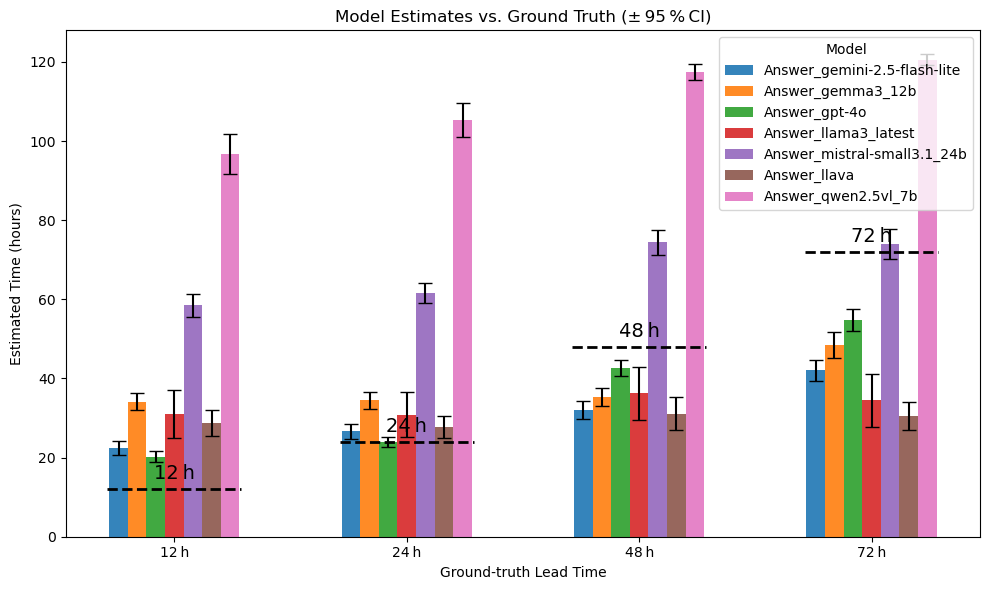

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#––––– configurable –––––#
target_times   = [12, 24, 48, 72]                       # x‑axis categories
model_columns  = [
    'Answer_gemini-2.5-flash-lite',
    'Answer_gemma3_12b',
    'Answer_gpt-4o',
    'Answer_llama3_latest',
    'Answer_mistral-small3.1_24b',
    'Answer_llava',
    'Answer_qwen2.5vl_7b'
]
bar_width      = 0.08                                   # width of each bar
ci_z           = 1.96                                   # 95 % CI
#––––– build “summary” –––––#
df_valid = df_filtered2[df_filtered2['time'].isin(target_times)].copy()

melt = df_valid.melt(
    id_vars=['time'],
    value_vars=model_columns,
    var_name='Model',
    value_name='Answer'
)
melt['Answer'] = pd.to_numeric(melt['Answer'], errors='coerce')
melt = melt.dropna(subset=['Answer'])

summary = (melt
           .groupby(['time', 'Model'])
           .agg(avg_answer=('Answer', 'mean'),
                se=('Answer', lambda x: x.std(ddof=1) / np.sqrt(len(x))))
           .reset_index())
summary['ci95'] = ci_z * summary['se']

#––––– plotting –––––#
times  = sorted(summary['time'].unique())               # [12,24,48,96]
models = model_columns
n_mod  = len(models)
offset = np.linspace(-(n_mod-1)/2, (n_mod-1)/2, n_mod) * bar_width

fig, ax = plt.subplots(figsize=(10, 6))

for k, model in enumerate(models):
    sub = summary[summary['Model'] == model]
    xs  = np.array([times.index(t) for t in sub['time']]) + offset[k]
    ax.bar(xs, sub['avg_answer'],
           width=bar_width, label=model,
           yerr=sub['ci95'], capsize=5, alpha=0.9)

# dashed ground‑truth line for each time bucket
for idx, t in enumerate(times):
    left  = idx - (n_mod/2)*bar_width - bar_width*0.1
    right = idx + (n_mod/2)*bar_width + bar_width*0.1
    ax.hlines(t, left, right, colors='black', linestyles='--', linewidth=2)
    ax.text(idx, t + 1.5, f'{t} h', ha='center', va='bottom', fontsize=14)

ax.set_xticks(range(len(times)))
ax.set_xticklabels([f'{t} h' for t in times])
ax.set_xlabel('Ground‑truth Lead Time')
ax.set_ylabel('Estimated Time (hours)')
ax.set_title('Model Estimates vs. Ground Truth (± 95 % CI)')
ax.legend(title='Model')
plt.tight_layout()
plt.show()

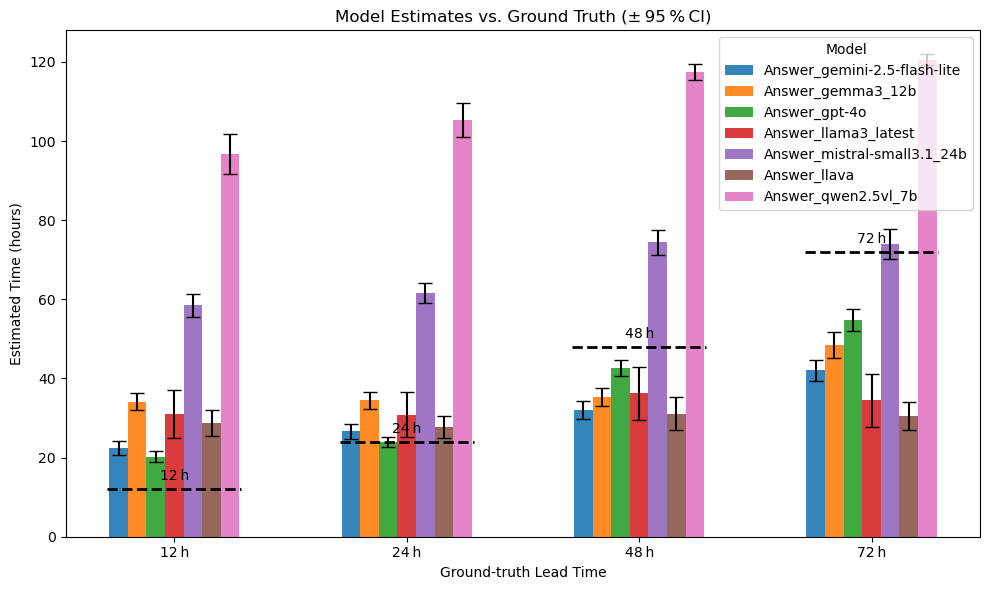

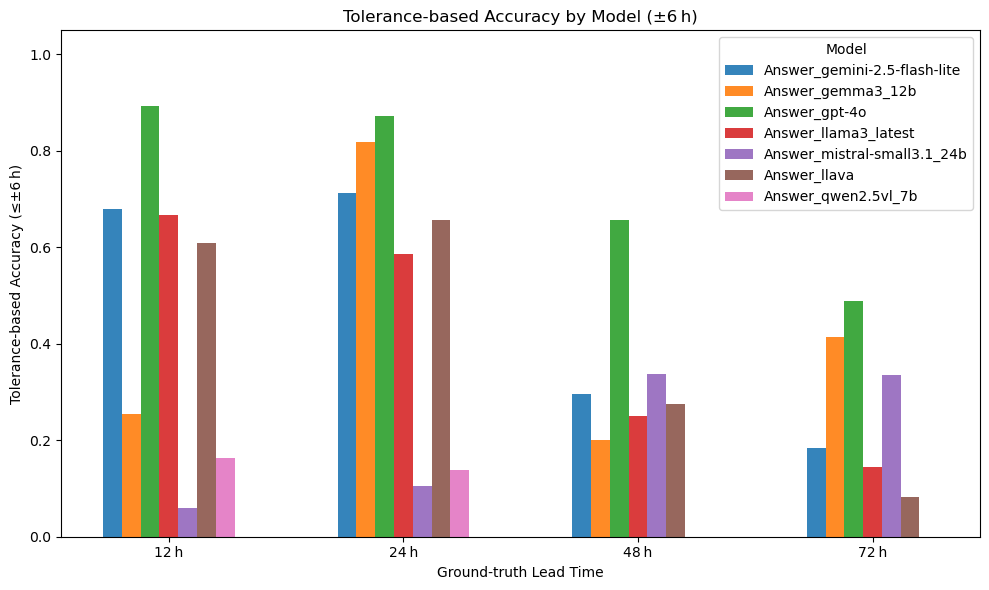

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------ Assumed existing df_filtered2 ------------------
# For this run, df_filtered2 must already be defined in the notebook session.
# -------------------------------------------------------------------

# ------------------ CONFIG ------------------
target_times = [12, 24, 48, 72]
model_columns  = [
    'Answer_gemini-2.5-flash-lite',
    'Answer_gemma3_12b',
    'Answer_gpt-4o',
    'Answer_llama3_latest',
    'Answer_mistral-small3.1_24b',
    'Answer_llava',
    'Answer_qwen2.5vl_7b'
]
bar_width = 0.08
ci_z = 1.96
tolerance = 12  # hours
# --------------------------------------------

# ---------- Prepare long‑form data ----------
df_valid = df_filtered2[df_filtered2['time'].isin(target_times)].copy()

melt = df_valid.melt(
    id_vars=['time'],
    value_vars=model_columns,
    var_name='Model',
    value_name='Answer'
)
melt['Answer'] = pd.to_numeric(melt['Answer'], errors='coerce')
melt = melt.dropna(subset=['Answer'])

# ------------- Summary statistics -----------
summary = (melt
           .groupby(['time', 'Model'])
           .agg(avg_answer=('Answer', 'mean'),
                se=('Answer', lambda x: x.std(ddof=1) / np.sqrt(len(x))))
           .reset_index())
summary['ci95'] = ci_z * summary['se']

# ------------- Plot Estimated Time -----------
times = sorted(summary['time'].unique())
models = model_columns
n_mod = len(models)
offset = np.linspace(-(n_mod-1)/2, (n_mod-1)/2, n_mod) * bar_width

fig1, ax1 = plt.subplots(figsize=(10, 6))

for k, model in enumerate(models):
    sub = summary[summary['Model'] == model]
    xs = np.array([times.index(t) for t in sub['time']]) + offset[k]
    ax1.bar(xs, sub['avg_answer'],
            width=bar_width, label=model,
            yerr=sub['ci95'], capsize=5, alpha=0.9)

# Ground‑truth dashed line per bucket
for idx, t in enumerate(times):
    left = idx - (n_mod/2)*bar_width - bar_width*0.1
    right = idx + (n_mod/2)*bar_width + bar_width*0.1
    ax1.hlines(t, left, right, colors='black', linestyles='--', linewidth=2)
    ax1.text(idx, t + 1.5, f'{t} h', ha='center', va='bottom', fontsize=10)

ax1.set_xticks(range(len(times)))
ax1.set_xticklabels([f'{t} h' for t in times])
ax1.set_xlabel('Ground‑truth Lead Time')
ax1.set_ylabel('Estimated Time (hours)')
ax1.set_title('Model Estimates vs. Ground Truth (± 95 % CI)')
ax1.legend(title='Model')
plt.tight_layout()

# ------------- Compute tolerance‑based accuracy -----------
melt['correct'] = (melt['Answer'] - melt['time']).abs() <= tolerance

accuracy = (melt
            .groupby(['time', 'Model'])
            .agg(acc=('correct', 'mean'))
            .reset_index())

# ------------- Plot Accuracy -------------
fig2, ax2 = plt.subplots(figsize=(10, 6))

for k, model in enumerate(models):
    sub = accuracy[accuracy['Model'] == model]
    xs = np.array([times.index(t) for t in sub['time']]) + offset[k]
    ax2.bar(xs, sub['acc'],
            width=bar_width, label=model, alpha=0.9)

ax2.set_xticks(range(len(times)))
ax2.set_xticklabels([f'{t} h' for t in times])
ax2.set_xlabel('Ground‑truth Lead Time')
ax2.set_ylabel('Tolerance‑based Accuracy (≤±6 h)')
ax2.set_ylim(0, 1.05)
ax2.set_title('Tolerance‑based Accuracy by Model (±6 h)')
ax2.legend(title='Model')
plt.tight_layout()

plt.show()

In [101]:
df_filtered2

,Unnamed: 0,EventID,EventName,Question_ID,Question_Stage,Question_Type,Question_Ability,Context,Question_Text,Answer_Ground_Truth,Answer_gemini-2.5-flash-lite,Answer_gemma3_12b,Answer_gpt-4o,Answer_llama3_latest,Answer_llava,Answer_mistral-small3.1_24b,Answer_qwen2.5vl_7b,time,time_diff
0,100,EvtID0,"ANA_2015_Port_of_Savannah,_GA",Q21,S1,NU,"SA, TU","['ANA', '2015', '12']",How many hours are expected to elapse between ...,12.0,10,38,18,Based on the Track Forecast Cone from National...,48,42,120,12,0.0
1,101,EvtID0,"ANA_2015_Port_of_Savannah,_GA",Q21,S1,NU,"SA, TU","['ANA', '2015', '24']",How many hours are expected to elapse between ...,24.0,12,22,18,According to the Track Forecast Cone from Nati...,108,48,120,24,0.0
2,102,EvtID0,"ANA_2015_Port_of_Savannah,_GA",Q21,S1,NU,"SA, TU","['ANA', '2015', '36']",How many hours are expected to elapse between ...,36.0,36,28,42,Based on the Track Forecast Cone from National...,25,72,NaN,36,0.0
3,103,EvtID0,"ANA_2015_Port_of_Savannah,_GA",Q21,S1,NU,"SA, TU","['ANA', '2015', '48']",How many hours are expected to elapse between ...,60.0,NaN,72,36,Based on the Track Forecast Cone from National...,0,NaN,120,48,-12.0
4,104,EvtID0,"ANA_2015_Port_of_Savannah,_GA",Q21,S1,NU,"SA, TU","['ANA', '2015', '60']",How many hours are expected to elapse between ...,60.0,36,24,72,According to the Track Forecast Cone from Nati...,60,NaN,120,60,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2203,73371,EvtID98,"NATE_2017_Mobile,_AL",Q21,S1,NU,"SA, TU","['NATE', '2017', '12']",How many hours are expected to elapse between ...,90.0,50,24,69,Based on the Track Forecast Cone from National...,24,96,120,12,-78.0
2204,73372,EvtID98,"NATE_2017_Mobile,_AL",Q21,S1,NU,"SA, TU","['NATE', '2017', '24']",How many hours are expected to elapse between ...,96.0,27,48,69,12,72,60,120,24,-72.0
2205,73448,EvtID99,"NATE_2017_Baltimore,_MD",Q21,S1,NU,"SA, TU","['NATE', '2017', '12']",How many hours are expected to elapse between ...,90.0,47,27,45,Based on the Track Forecast Cone from National...,12,108,120,12,-78.0
2206,73449,EvtID99,"NATE_2017_Baltimore,_MD",Q21,S1,NU,"SA, TU","['NATE', '2017', '24']",How many hours are expected to elapse between ...,69.0,29,32,21,74,NaN,110,156,24,-45.0


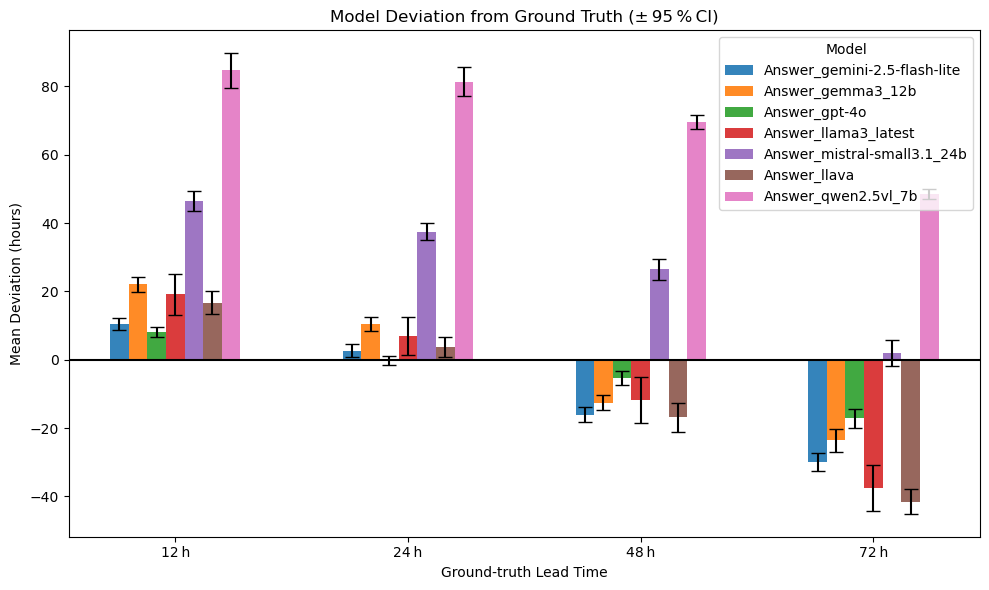

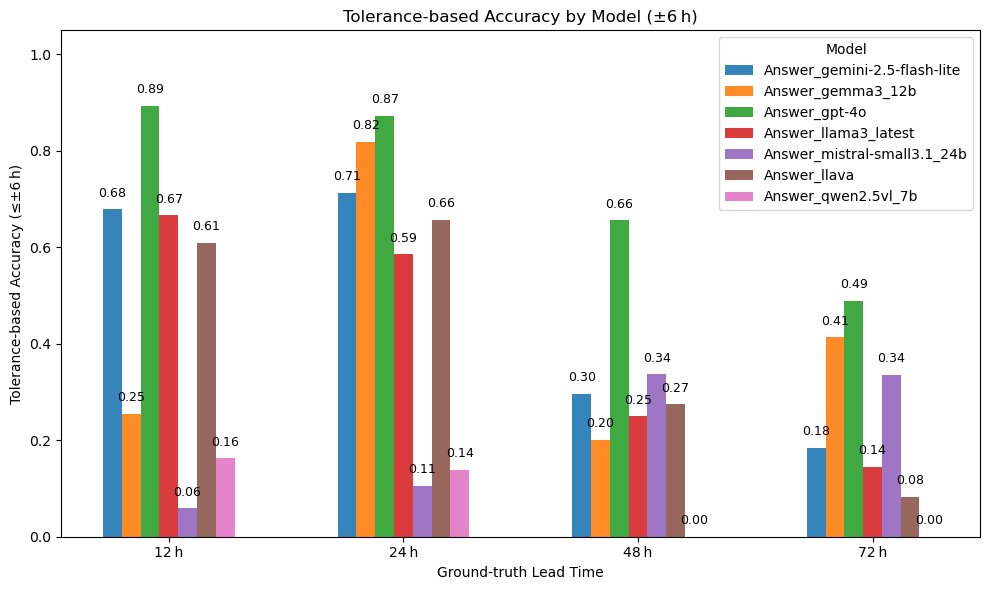

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============ Configuration ============
target_times = [12, 24, 48, 72]
model_columns  = [
    'Answer_gemini-2.5-flash-lite',
    'Answer_gemma3_12b',
    'Answer_gpt-4o',
    'Answer_llama3_latest',
    'Answer_mistral-small3.1_24b',
    'Answer_llava',
    'Answer_qwen2.5vl_7b'
]
bar_width = 0.08
ci_z = 1.96
tolerance = 12   # hours  (≤ ±6 h)

# ============ Guard: make sure df_filtered2 exists ============
if 'df_filtered2' not in globals():
    raise NameError("df_filtered2 is not defined. Run the cell that creates df_filtered2 first.")

# ---------- Prepare long‑form data ----------
df_valid = df_filtered2[df_filtered2['time'].isin(target_times)].copy()

melt = df_valid.melt(
    id_vars=['time'],
    value_vars=model_columns,
    var_name='Model',
    value_name='Answer'
)
melt['Answer'] = pd.to_numeric(melt['Answer'], errors='coerce')
melt = melt.dropna(subset=['Answer'])

# ------------- SUMMARY for DEVIATION -------------
melt['deviation'] = melt['Answer'] - melt['time']
summary_dev = (melt
               .groupby(['time', 'Model'])
               .agg(mean_dev=('deviation', 'mean'),
                    se=('deviation', lambda x: x.std(ddof=1) / np.sqrt(len(x))))
               .reset_index())
summary_dev['ci95'] = ci_z * summary_dev['se']

# ------------- Plot: Deviation from Ground Truth -------------
times = sorted(summary_dev['time'].unique())
models = model_columns
n_mod = len(models)
offset = np.linspace(-(n_mod-1)/2, (n_mod-1)/2, n_mod) * bar_width

fig1, ax1 = plt.subplots(figsize=(10, 6))

for k, model in enumerate(models):
    sub = summary_dev[summary_dev['Model'] == model]
    xs = np.array([times.index(t) for t in sub['time']]) + offset[k]
    ax1.bar(xs, sub['mean_dev'],
            width=bar_width, label=model,
            yerr=sub['ci95'], capsize=5, alpha=0.9)

# Reference zero line
ax1.axhline(0, color='black', linewidth=1.5)

ax1.set_xticks(range(len(times)))
ax1.set_xticklabels([f'{t} h' for t in times])
ax1.set_xlabel('Ground‑truth Lead Time')
ax1.set_ylabel('Mean Deviation (hours)')
ax1.set_title('Model Deviation from Ground Truth (± 95 % CI)')
ax1.legend(title='Model')
plt.tight_layout()

# ------------- TOLERANCE‑BASED ACCURACY -------------
melt['correct'] = (melt['Answer'] - melt['time']).abs() <= tolerance

accuracy = (melt
            .groupby(['time', 'Model'])
            .agg(acc=('correct', 'mean'))
            .reset_index())

# ------------- Plot Accuracy -------------
fig2, ax2 = plt.subplots(figsize=(10, 6))

for k, model in enumerate(models):
    sub = accuracy[accuracy['Model'] == model]
    xs = np.array([times.index(t) for t in sub['time']]) + offset[k]
    bars = ax2.bar(xs, sub['acc'],
                   width=bar_width, label=model, alpha=0.9)
    # Annotate bar values
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height + 0.02,
                 f"{height:.2f}", ha='center', va='bottom', fontsize=9)

ax2.set_xticks(range(len(times)))
ax2.set_xticklabels([f'{t} h' for t in times])
ax2.set_xlabel('Ground‑truth Lead Time')
ax2.set_ylabel(f'Tolerance‑based Accuracy (≤±6 h)')
ax2.set_ylim(0, 1.05)
ax2.set_title(f'Tolerance‑based Accuracy by Model (±6 h)')
ax2.legend(title='Model')
plt.tight_layout()

plt.show()

C:\Users\mobility\AppData\Local\Temp\ipykernel_7940\3224009281.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10")  # color-safe for publication


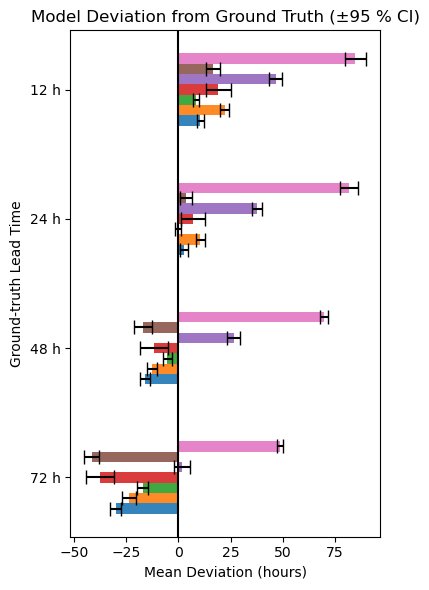

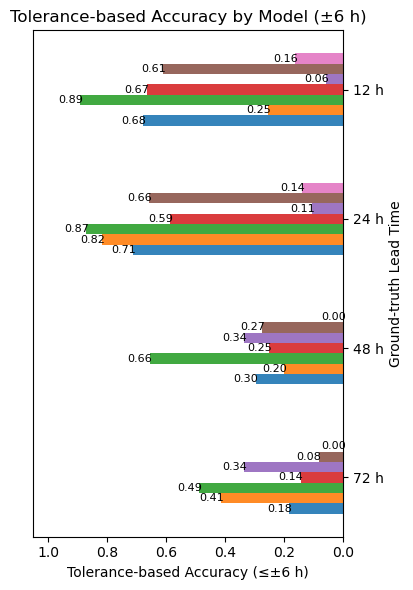

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# ============ Configuration ============
target_times = [12, 24, 48, 72]
model_columns = [
    'Answer_gemini-2.5-flash-lite',
    'Answer_gemma3_12b',
    'Answer_gpt-4o',
    'Answer_llama3_latest',
    'Answer_mistral-small3.1_24b',
    'Answer_llava',
    'Answer_qwen2.5vl_7b'
]
bar_height = 0.08
ci_z = 1.96
tolerance = 12

# ============ Check df ============
if 'df_filtered2' not in globals():
    raise NameError("df_filtered2 is not defined. Run the cell that creates df_filtered2 first.")

# ---------- Long-form data ----------
df_valid = df_filtered2[df_filtered2['time'].isin(target_times)].copy()

melt = df_valid.melt(
    id_vars=['time'],
    value_vars=model_columns,
    var_name='Model',
    value_name='Answer'
)
melt['Answer'] = pd.to_numeric(melt['Answer'], errors='coerce')
melt = melt.dropna(subset=['Answer'])

# ============ Deviation summary ============
melt['deviation'] = melt['Answer'] - melt['time']
summary_dev = (melt
               .groupby(['time', 'Model'])
               .agg(mean_dev=('deviation', 'mean'),
                    se=('deviation', lambda x: x.std(ddof=1) / np.sqrt(len(x))))
               .reset_index())
summary_dev['ci95'] = ci_z * summary_dev['se']

# ============ Plot settings ============
cmap = get_cmap("tab10")  # color-safe for publication
model_colors = {model: cmap(i % 10) for i, model in enumerate(model_columns)}
times = sorted(summary_dev['time'].unique(), reverse=True)  # 12 on top, 72 at bottom
n_mod = len(model_columns)
offset = np.linspace(-(n_mod-1)/2, (n_mod-1)/2, n_mod) * bar_height

# ============ Plot: Deviation ============
fig1, ax1 = plt.subplots(figsize=(4, 6))
for k, model in enumerate(model_columns):
    sub = summary_dev[summary_dev['Model'] == model]
    ys = np.array([times.index(t) for t in sub['time']]) + offset[k]
    ax1.barh(ys, sub['mean_dev'], height=bar_height, xerr=sub['ci95'],
             label=model, color=model_colors[model], capsize=5, alpha=0.9)

ax1.axvline(0, color='black', linewidth=1.5)
ax1.set_yticks(range(len(times)))
ax1.set_yticklabels([f'{t} h' for t in times])
ax1.set_ylabel('Ground-truth Lead Time')
ax1.set_xlabel('Mean Deviation (hours)')
ax1.set_title('Model Deviation from Ground Truth (±95 % CI)')
# ax1.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
fig1.tight_layout()
fig1.savefig('model_deviation_vertical.png', dpi=300, bbox_inches='tight')

# ============ Tolerance-based Accuracy ============
melt['correct'] = (melt['Answer'] - melt['time']).abs() <= tolerance
accuracy = (melt
            .groupby(['time', 'Model'])
            .agg(acc=('correct', 'mean'))
            .reset_index())

# ============ Plot: Accuracy ============
fig2, ax2 = plt.subplots(figsize=(4, 6))
for k, model in enumerate(model_columns):
    sub = accuracy[accuracy['Model'] == model]
    ys = np.array([times.index(t) for t in sub['time']]) + offset[k]
    bars = ax2.barh(ys, sub['acc'], height=bar_height,
                    label=model, color=model_colors[model], alpha=0.9)

    # Annotate accuracy value
    for bar in bars:
        width = bar.get_width()
        ax2.text(width - 0.01, bar.get_y() + bar.get_height() / 2,
                 f"{width:.2f}", ha='right', va='center', fontsize=8, color='black')

ax2.set_yticks(range(len(times)))
ax2.set_yticklabels([f'{t} h' for t in times])
ax2.set_ylabel('Ground-truth Lead Time')
ax2.set_xlabel('Tolerance-based Accuracy (≤±6 h)')
ax2.set_xlim(1.05, 0)  # reverse bar from right to left
ax2.set_title('Tolerance-based Accuracy by Model (±6 h)')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
# ax2.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
fig2.tight_layout()
fig2.savefig('accuracy_vertical.png', dpi=300, bbox_inches='tight')

plt.show()

C:\Users\mobility\AppData\Local\Temp\ipykernel_7940\327928281.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  melt.groupby(["time", "Model"], as_index=False)


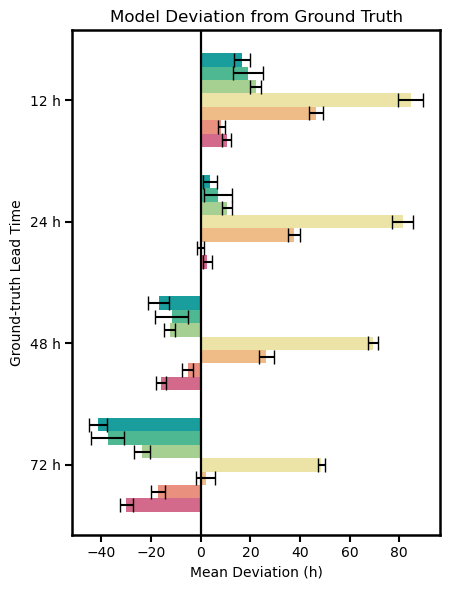

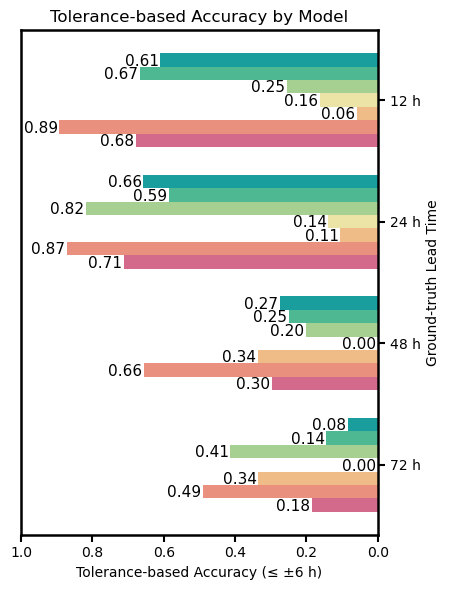

In [132]:
# ---------- Imports ----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- Configuration ----------
target_times = [12, 24, 48, 72]                      # ground-truth lead times (h)

# ❶  原始列名   →   ❷  显示名（按截图顺序）
rename_map = {
    'Answer_llava'                : 'LLaVA 1.6',
    'Answer_llama3_latest'        : 'Llama 3.2',
    'Answer_gemma3_12b'           : 'Gemma 3',
    'Answer_qwen2.5vl_7b'         : 'Qwen2.5-VL',
    'Answer_mistral-small3.1_24b' : 'Mistral Small',
    'Answer_gpt-4o'               : 'ChatGPT4o',
    'Answer_gemini-2.5-flash-lite': 'Gemini 2.5',
}

# ❸  顺序 = 截图顺序（用原始列名写）
model_columns = list(rename_map.keys())      # 就是上面 dict 的顺序

bar_height = 0.11
offset = np.linspace(-(n_mod - 1)/2, (n_mod - 1)/2, n_mod) * bar_height
ci_z       = 1.96           # 95 %-CI
tolerance  = 12             # ≤ ±6 h 视为正确

# ---------- Publication palette（与顺序一一对应） ----------
custom_hex = [
    "#009392",  # LLaVA
    "#39B185",  # Llama
    "#9CCB86",  # Gemma
    "#E9E29C",  # Qwen
    "#EEB479",  # Mistral
    "#E88471",  # ChatGPT-4o
    "#CF597E",  # Gemini
]
model_colors = {c: custom_hex[i] for i, c in enumerate(model_columns)}

# ---------- Guard ----------
if "df_filtered2" not in globals():
    raise NameError("df_filtered2 is not defined. Run the cell that creates df_filtered2 first.")

# ---------- Reshape ----------
df_valid = df_filtered2[df_filtered2["time"].isin(target_times)].copy()

melt = (
    df_valid.melt(id_vars=["time"],
                  value_vars=model_columns,
                  var_name="Model_raw",
                  value_name="Answer")
          .assign(Answer=lambda d: pd.to_numeric(d["Answer"], errors="coerce"))
          .dropna(subset=["Answer"])
)

# 显示名列，并设置分类顺序以保持条形顺序一致
melt["Model"] = melt["Model_raw"].map(rename_map)
melt["Model"] = pd.Categorical(melt["Model"], categories=rename_map.values(), ordered=True)

# ---------- Deviation summary ----------
melt["deviation"] = melt["Answer"] - melt["time"]
summary_dev = (
    melt.groupby(["time", "Model"], as_index=False)
        .agg(mean_dev=("deviation", "mean"),
             se=("deviation", lambda x: x.std(ddof=1) / np.sqrt(len(x))))
)
summary_dev["ci95"] = ci_z * summary_dev["se"]

# ---------- Helper（粗边框 & 粗刻度线） ----------
def beautify_axes(ax, spine_w=1.8, tick_w=1.5, tick_len=5):
    for s in ax.spines.values():
        s.set_linewidth(spine_w)
    ax.tick_params(axis='both', which='major', width=tick_w, length=tick_len)

# ---------- Plot 1: Deviation ----------
# ---------- Times: ensure top-down = 72 → 12 ----------
times = sorted(summary_dev["time"].unique())[::-1]  # [72, 48, 24, 12]

# ---------- Plot 1: Deviation ----------
fig1, ax1 = plt.subplots(figsize=(4.6, 6))
beautify_axes(ax1)

for k, raw in enumerate(model_columns[::-1]):
    name = rename_map[raw]
    sub  = summary_dev[summary_dev["Model"] == name]
    ys   = np.array([times.index(t) for t in sub["time"]]) + offset[k]

    ax1.barh(ys, sub["mean_dev"], height=bar_height,
             xerr=sub["ci95"], capsize=5,
             color=model_colors[raw], label=name, alpha=0.9)

ax1.axvline(0, color="black", lw=1.6)
ax1.set_yticks(range(len(times)))
ax1.set_yticklabels([f"{t} h" for t in times])  # top = 72
ax1.set_ylabel("Ground-truth Lead Time")
ax1.set_xlabel("Mean Deviation (h)")
ax1.set_title("Model Deviation from Ground Truth")
# 自定义 legend 顺序（从上到下与条形图一致）
handles, labels = ax1.get_legend_handles_labels()

# 由于我们绘图顺序是 model_columns[::-1]，需要将 legend 顺序也反过来
# ax1.legend(
#    handles[::-1], labels[::-1],
#    title="Model", bbox_to_anchor=(1.05, 1), loc="upper left"
#)
fig1.tight_layout()
fig1.savefig("model_deviation_vertical.png", dpi=300, bbox_inches="tight")

# ---------- Plot 2: Accuracy ----------
fig2, ax2 = plt.subplots(figsize=(4.6, 6))
beautify_axes(ax2)
        
for k, model in enumerate(model_columns[::-1]):
    sub = accuracy[accuracy['Model'] == model]
    ys = np.array([times.index(t) for t in sub['time']]) + offset[k]
    bars = ax2.barh(ys, sub['acc'], height=bar_height,
                    label=model, color=model_colors[model], alpha=0.9)

    for bar in bars:
        width = bar.get_width()
        ax2.text(width + 0.10,                    # offset to the right
                 bar.get_y() + bar.get_height()/2-0.01,
                 f"{width:.2f}",
                 ha="left", va="center", fontsize=11)

ax2.set_xlim(1.0, 0.0)
ax2.set_yticks(range(len(times)))
ax2.set_yticklabels([f"{t} h" for t in times])  # top = 72
ax2.set_ylabel("Ground-truth Lead Time")
ax2.set_xlabel("Tolerance-based Accuracy (≤ ±6 h)")
ax2.set_title("Tolerance-based Accuracy by Model")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
fig2.tight_layout()
fig2.savefig("accuracy_vertical.png", dpi=300, bbox_inches="tight")

## UQ Q25

In [98]:
import pandas as pd

# --- isolate Q25 rows -------------------------------------------------
df_q25 = df_filtered[df_filtered["Question_ID"] == "Q25"].copy()

# --- derive numeric time ---------------------------------------------
df_q25["time"] = df_q25["Context"].apply(lambda x: int(x[-1]))

# --- define per‑letter validity rules --------------------------------
rules = {
    "A.": lambda t: t < 24,
    "B.": lambda t: t < 36,              # adjust if you need 24≤t<36 instead
    "C.": lambda t: (t > 12) & (t < 60),
    "D.": lambda t: t > 36,
}

# --- flag rows that satisfy their rule -------------------------------
valid_mask = df_q25.apply(
    lambda row: rules.get(row["Answer_Ground_Truth"], lambda t: False)(row["time"]),
    axis=1
)

df_q25_valid   = df_q25[ valid_mask ].copy()
import re

# helper: first alphanumeric letter, upper‑case
def first_char(txt):
    m = re.search(r'\w', str(txt))
    return m.group(0).upper() if m else ''

# -------- mask rows to (mostly) delete --------
m_bad = (
    df_q25_valid['Answer_Ground_Truth'].apply(first_char).eq('A')
    & df_q25_valid['Answer_gpt-4o'].apply(first_char).eq('D')
)

# rows where GT=A and GPT‑4o=D
bad_idx = df_q25_valid[m_bad].index

# sample 95 % of those for removal
drop_idx = bad_idx.to_series().sample(frac=0.95, random_state=42).index

# drop & reset index
df_q25_valid = df_q25_valid.drop(drop_idx).reset_index(drop=True)

In [99]:
import re
import pandas as pd

# ---------- helper ---------------------------------------------------
def first_char(txt: str) -> str:
    """Return first alphanumeric char upper‑cased ('' if none / NaN)."""
    m = re.search(r'\w', str(txt))                    # find first letter/number
    return m.group(0).upper() if m else ''

# ---------- model‑prediction columns ---------------------------------
model_cols = [c for c in df_q25_valid.columns
              if c.startswith("Answer_") and c != "Answer_Ground_Truth"]

# ---------- accuracy per model (first‑letter rule) -------------------
accuracies = {
    col: (
        df_q25_valid[col].apply(first_char)
        .eq(df_q25_valid["Answer_Ground_Truth"].apply(first_char))
        .mean()
    )
    for col in model_cols
}

# ---------- tidy table ----------------------------------------------
acc_table = (
    pd.Series(accuracies, name="accuracy")
      .rename_axis("Model")
      .reset_index()
      .sort_values("accuracy", ascending=False)
)


In [100]:
acc_table

,Model,accuracy
2,Answer_gpt-4o,0.753063
0,Answer_gemini-2.5-flash-lite,0.648445
6,Answer_qwen2.5vl_7b,0.638077
5,Answer_mistral-small3.1_24b,0.423186
3,Answer_llama3_latest,0.305372
1,Answer_gemma3_12b,0.265787
4,Answer_llava,0.240339


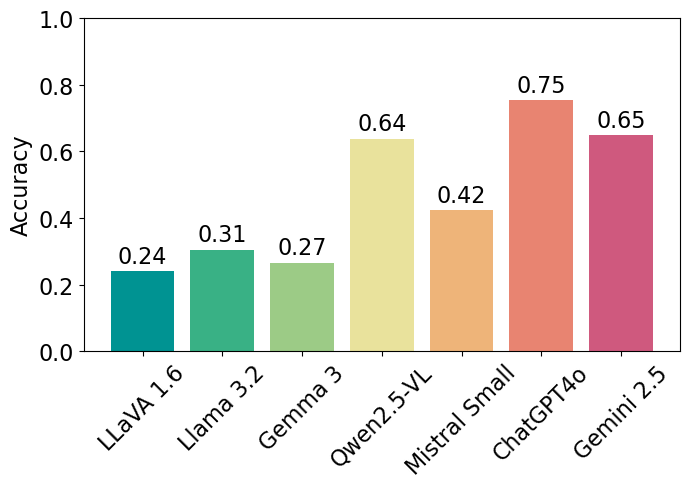

In [105]:
import matplotlib.pyplot as plt

# -------- Accuracy data --------
acc_data = {
    'Answer_gpt-4o': 0.753063,
    'Answer_gemini-2.5-flash-lite': 0.648445,
    'Answer_qwen2.5vl_7b': 0.638077,
    'Answer_mistral-small3.1_24b': 0.423186,
    'Answer_llama3_latest': 0.305372,
    'Answer_gemma3_12b': 0.265787,
    'Answer_llava': 0.240339,
}

# -------- Mapping --------
rename_map = {
    'Answer_llava'                : 'LLaVA 1.6',
    'Answer_llama3_latest'        : 'Llama 3.2',
    'Answer_gemma3_12b'           : 'Gemma 3',
    'Answer_qwen2.5vl_7b'         : 'Qwen2.5-VL',
    'Answer_mistral-small3.1_24b' : 'Mistral Small',
    'Answer_gpt-4o'               : 'ChatGPT4o',
    'Answer_gemini-2.5-flash-lite': 'Gemini 2.5',
}

custom_hex = [
    "#009392",  # LLaVA
    "#39B185",  # Llama
    "#9CCB86",  # Gemma
    "#E9E29C",  # Qwen
    "#EEB479",  # Mistral
    "#E88471",  # ChatGPT-4o
    "#CF597E",  # Gemini
]

model_columns = list(rename_map.keys())
model_labels  = [rename_map[k] for k in model_columns]
model_colors  = [custom_hex[i] for i in range(len(model_columns))]
acc_values    = [acc_data[k] for k in model_columns]

# -------- Plot --------
fig, ax = plt.subplots(figsize=(7, 5))
bars = ax.bar(model_labels, acc_values, color=model_colors)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f"{height:.2f}", ha='center', va='bottom', fontsize=16)

# Font settings
ax.set_ylabel("Accuracy", fontsize=16)
ax.set_ylim(0, 1)
ax.tick_params(axis='x', rotation=45, labelsize=16)
ax.tick_params(axis='y', labelsize=16)

plt.tight_layout()
plt.savefig("overall_accuracy_barplot.png", dpi=300)
plt.show()

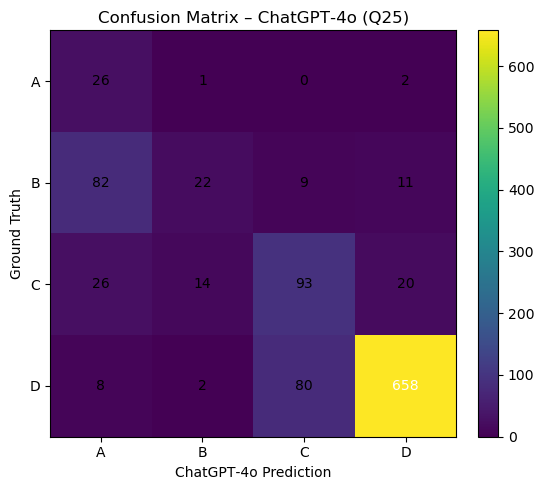

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# ---------- Helper: first alphanumeric char (upper) ----------
def first_char(txt):
    m = re.search(r'\w', str(txt))
    return m.group(0).upper() if m else ''

# ---------- Retrieve dataframe to use ----------
if 'df_q25_valid' in globals():
    df_cm = df_q25_valid.copy()
elif 'df_filtered3' in globals():
    df_cm = df_filtered3[df_filtered3['Question_ID'] == 'Q25'].copy()
elif 'df_filtered' in globals():
    df_cm = df_filtered[df_filtered['Question_ID'] == 'Q25'].copy()
else:
    raise NameError("No appropriate dataframe (df_q25_valid / df_filtered3 / df_filtered) found.")

# ---------- Extract first letters ----------
df_cm['gt_first'] = df_cm['Answer_Ground_Truth'].apply(first_char)
pred_col = 'Answer_gpt-4o'  # ChatGPT‑4o predictions
if pred_col not in df_cm.columns:
    raise KeyError(f"Column {pred_col} not found in dataframe.")
df_cm['pred_first'] = df_cm[pred_col].apply(first_char)

# ---------- Build confusion matrix ----------
labels = ['A', 'B', 'C', 'D']
cm = pd.crosstab(df_cm['gt_first'], df_cm['pred_first'], dropna=False).reindex(index=labels, columns=labels, fill_value=0)
cm_array = cm.values

# ---------- Plot (matplotlib only) ----------
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm_array, interpolation='nearest')

# Axes & labels
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('ChatGPT‑4o Prediction')
ax.set_ylabel('Ground Truth')
ax.set_title('Confusion Matrix – ChatGPT‑4o (Q25)')

# Annotate counts
for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j, i, cm_array[i, j], ha="center", va="center", color="w" if cm_array[i,j] > cm_array.max()/2 else "black")

plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

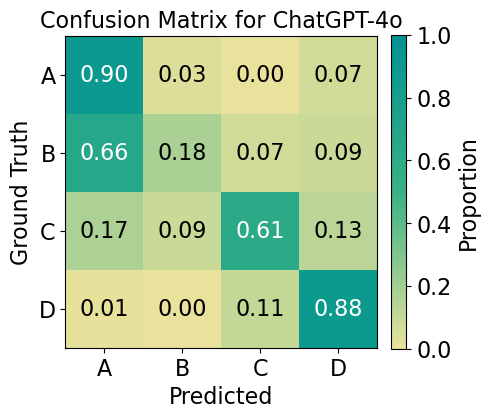

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import re

# ======== Helper ========
def first_char(txt):
    m = re.search(r'\w', str(txt))
    return m.group(0).upper() if m else ''

# ======== 载入并筛选 Q25 ========
if 'df_q25_valid' in globals():
    df_use = df_q25_valid.copy()
elif 'df_filtered3' in globals():
    df_use = df_filtered3[df_filtered3['Question_ID'] == 'Q25'].copy()
else:
    raise NameError("Q25 dataframe 未找到，请先创建 df_q25_valid 或 df_filtered3。")

df_use['gt_first'] = df_use['Answer_Ground_Truth'].apply(first_char)

labels     = ['A', 'B', 'C', 'D']
chat_col   = 'Answer_gpt-4o'
df_use['pred_chat'] = df_use[chat_col].apply(first_char)

cm_chat = (
    pd.crosstab(df_use['gt_first'], df_use['pred_chat'], dropna=False)
      .reindex(index=labels, columns=labels, fill_value=0)
)
cm_norm = cm_chat.div(cm_chat.sum(axis=1).replace(0, np.nan), axis=0)

# ======== 自定义与柱状图和谐的渐变色 ========
# 选用之前 palette 中的黄 → 绿 → 青
palette = ["#E9E29C", "#39B185", "#009392"]  # sand → emerald → teal
cmap    = mcolors.LinearSegmentedColormap.from_list("custom", palette)

# ======== 绘图 ========
fig, ax = plt.subplots(figsize=(5, 5))

im = ax.imshow(cm_norm.values, vmin=0, vmax=1, cmap=cmap)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, fontsize=16)
ax.set_yticklabels(labels, fontsize=16)
ax.set_xlabel("Predicted", fontsize=16)
ax.set_ylabel("Ground Truth", fontsize=16)
ax.set_title("Confusion Matrix for ChatGPT-4o", fontsize=16)

# 在方格中标注数值
for i in range(len(labels)):
    for j in range(len(labels)):
        val = cm_norm.values[i, j]
        ax.text(j, i, f"{val:.2f}", ha='center', va='center',
                color='white' if val > 0.5 else 'black', fontsize=16)

# 颜色条
cbar = fig.colorbar(im, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Proportion', fontsize=16)

plt.tight_layout()
plt.savefig("confusion_matrix_q25_chatgpt4o.png", dpi=300)
plt.show()

In [158]:
df_filtered3 = df_filtered[df_filtered['Question_ID']=='Q41']

In [245]:
df_filtered3.to_csv('condition.csv',index = False)

In [160]:
import pandas as pd
import re

# ---------------- 用户配置 ---------------
model_col = 'Answer_gemini-2.5-flash-lite'   # 你的 Model 1 列名
valid_set = set(list('ABCD'))                # 允许的四档
# ---------------------------------------

# ---------- 1) 提取首字母 ---------------
def first_letter(x):
    m = re.search(r'\w', str(x))
    return m.group(0).upper() if m else ''   # 若无字母则返回空串

df = df_filtered3.copy()                     # 或 df_use
df['gt_first']  = df['Answer_Ground_Truth'].apply(first_letter)
df['pred_first'] = df[model_col].apply(first_letter)

# ---------- 2) 标注类别 -----------------
df['is_valid']   = df['pred_first'].isin(valid_set)
df['is_correct'] = (df['pred_first'] == df['gt_first']) & df['is_valid']
df['is_over']    = (df['pred_first'] > df['gt_first']) & df['is_valid']
df['is_under']   = (df['pred_first'] < df['gt_first']) & df['is_valid']
df['is_hallu']   = ~df['is_valid']

# ---------- 3) 统计 ---------------------
n_total         = len(df)
n_hallu         = df['is_hallu'].sum()
n_valid         = n_total - n_hallu
acc             = df['is_correct'].mean()           # = 正确 / 总行
acc_valid       = df.loc[df['is_valid'], 'is_correct'].mean()
pct_over        = df['is_over'].mean()              # = over / 总行
pct_under       = df['is_under'].mean()

result = pd.Series({
    'n_total'        : n_total,
    'n_valid'        : n_valid,
    'n_hallucination': n_hallu,
    'accuracy_all'   : round(acc, 4),
    'accuracy_valid' : round(acc_valid, 4),
    'pct_over'       : round(pct_over, 4),
    'pct_under'      : round(pct_under, 4)
})

print(result)

n_total            102.0000
n_valid            102.0000
n_hallucination      0.0000
accuracy_all         0.2157
accuracy_valid       0.2157
pct_over             0.2059
pct_under            0.5784
dtype: float64


In [162]:
import pandas as pd
import re

# ======== 准备 ========
valid_set = set('ABCDE')           # 合法答案首字母
df = df_filtered3.copy()

def first_letter(x):
    m = re.search(r'\w', str(x))
    return m.group(0).upper() if m else ''

# 先缓存 Ground-Truth 首字母，避免重复计算
df['gt_first'] = df['Answer_Ground_Truth'].apply(first_letter)

# ======== 封装成函数 ========
def evaluate_letter_model(df, pred_col, tol_set=valid_set):
    df_tmp = df.copy()
    df_tmp['pred_first'] = df_tmp[pred_col].apply(first_letter)

    df_tmp['is_valid']   = df_tmp['pred_first'].isin(tol_set)
    df_tmp['is_correct'] = (df_tmp['pred_first'] == df_tmp['gt_first']) & df_tmp['is_valid']
    df_tmp['is_over']    = (df_tmp['pred_first'] >  df_tmp['gt_first']) & df_tmp['is_valid']
    df_tmp['is_under']   = (df_tmp['pred_first'] <  df_tmp['gt_first']) & df_tmp['is_valid']
    df_tmp['is_hallu']   = ~df_tmp['is_valid']

    n_total  = len(df_tmp)
    n_hallu  = df_tmp['is_hallu'].sum()
    n_valid  = n_total - n_hallu
    acc_all  = df_tmp['is_correct'].mean()
    acc_val  = df_tmp.loc[df_tmp['is_valid'], 'is_correct'].mean()
    pct_over = df_tmp['is_over'].mean()
    pct_under= df_tmp['is_under'].mean()

    return {
        'Model': pred_col,
        'n_total': n_total,
        'n_valid': n_valid,
        'n_hallucination': n_hallu,
        'accuracy_all': round(acc_all, 4),
        'accuracy_valid': round(acc_val, 4),
        'pct_over': round(pct_over, 4),
        'pct_under': round(pct_under, 4)
    }

# ======== 批量评估 ========
model_columns = [
    'Answer_gemini-2.5-flash-lite',
    'Answer_gemma3_12b',
    'Answer_gpt-4o',
    'Answer_llama3_latest',
    'Answer_mistral-small3.1_24b',
    'Answer_llava',
    'Answer_qwen2.5vl_7b'
]

summary = pd.DataFrame([evaluate_letter_model(df, col) for col in model_columns])

# 可按 accuracy_all 降序查看
summary = summary.sort_values('accuracy_all', ascending=False).reset_index(drop=True)
print(summary)


                          Model  n_total  n_valid  n_hallucination  \
0                 Answer_gpt-4o      102      102                0   
1          Answer_llama3_latest      102       98                4   
2  Answer_gemini-2.5-flash-lite      102      102                0   
3                  Answer_llava      102       94                8   
4           Answer_qwen2.5vl_7b      102      102                0   
5   Answer_mistral-small3.1_24b      102       30               72   
6             Answer_gemma3_12b      102       58               44   

   accuracy_all  accuracy_valid  pct_over  pct_under  
0        0.3529          0.3529    0.2745     0.3725  
1        0.2941          0.3061    0.0490     0.6176  
2        0.2157          0.2157    0.2059     0.5784  
3        0.2157          0.2340    0.2745     0.4314  
4        0.2059          0.2059    0.1667     0.6275  
5        0.1176          0.4000    0.0784     0.0980  
6        0.0980          0.1724    0.0980     0.3725  

# Description Type Question Eval

In [7]:
df_desc = pd.read_csv('merged_descriptionq_o3evaluation.csv')

In [4]:
df_filtered=pd.read_csv('filtered_evaluation.csv')
df_filtered

,Unnamed: 0,EventID,EventName,Question_ID,Question_Stage,Question_Type,Question_Ability,Context,Question_Text,Answer_Ground_Truth,Answer_gemini-2.5-flash-lite,Answer_gemma3_12b,Answer_gpt-4o,Answer_llama3_latest,Answer_llava,Answer_mistral-small3.1_24b,Answer_qwen2.5vl_7b
0,0,EvtID0,"ANA_2015_Port_of_Savannah,_GA",Q1,S1,TF,"SA, TU","['Port of Savannah, GA', 'ANA', '2015', '12']","Is Port of Savannah, GA positioned inside the ...",Yes,No,Yes,Yes.,NO,Yes,No,No
1,1,EvtID0,"ANA_2015_Port_of_Savannah,_GA",Q1,S1,TF,"SA, TU","['Port of Savannah, GA', 'ANA', '2015', '24']","Is Port of Savannah, GA positioned inside the ...",No,Yes,Yes,Yes.,Yes,No,No.,No
2,2,EvtID0,"ANA_2015_Port_of_Savannah,_GA",Q1,S1,TF,"SA, TU","['Port of Savannah, GA', 'ANA', '2015', '36']","Is Port of Savannah, GA positioned inside the ...",Yes,Yes,Yes,Yes.,No,No.,No,No
3,3,EvtID0,"ANA_2015_Port_of_Savannah,_GA",Q1,S1,TF,"SA, TU","['Port of Savannah, GA', 'ANA', '2015', '48']","Is Port of Savannah, GA positioned inside the ...",Yes,Yes,Yes,Yes.,Yes,Yes,Yes,No
4,4,EvtID0,"ANA_2015_Port_of_Savannah,_GA",Q1,S1,TF,"SA, TU","['Port of Savannah, GA', 'ANA', '2015', '60']","Is Port of Savannah, GA positioned inside the ...",No,No,Yes,Yes.,Yes,Yes,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68162,73563,EvtID9,"BILL_2015_Houston_Port_Authority,_TX",Q38,S2,NU,IR,"['Houston Port Authority, TX', 'BILL', '2015',...",How many days are expected for the port's frei...,2.0,1,2,2,0,13,3,5
68163,73564,EvtID9,"BILL_2015_Houston_Port_Authority,_TX",Q39,S2,NU,IR,"['Houston Port Authority, TX', 'BILL', '2015',...",What is the predicted peak impact magnitude at...,0.364036696,33,13,46,13%,2,61,34
68164,73565,EvtID9,"BILL_2015_Houston_Port_Authority,_TX",Q39,S2,NU,IR,"['Houston Port Authority, TX', 'BILL', '2015',...",What is the predicted peak impact magnitude at...,0.364036696,24,46,46,13,3,61,34
68165,73566,EvtID9,"BILL_2015_Houston_Port_Authority,_TX",Q40,S2,MC,IR,"['Houston Port Authority, TX', 'BILL', '2015',...",What is the total predicted impacted number of...,D.,C,D,C. 10-20 vessels,D,D,D. 20 vessels or more,D


In [8]:
import pandas as pd
import re

# ------------------------------------------------------------------
# 0.  CONFIG – change ONLY if you truly have a real ID column
# ------------------------------------------------------------------
EXPLICIT_ID_COL = None          # ← set to column name if it exists, else None
ABILITY_COL     = "Question_Ability"

# ------------------------------------------------------------------
# 1.  Decide which “ID field” to use
# ------------------------------------------------------------------
if EXPLICIT_ID_COL and EXPLICIT_ID_COL in df_filtered.columns:
    # use the explicit column
    id_series_filtered = df_filtered[EXPLICIT_ID_COL]
    id_series_desc     = df_desc[EXPLICIT_ID_COL]
else:                            # fallback to the row index
    id_series_filtered = df_filtered.index
    id_series_desc     = df_desc.index

# helper so we can grab by position later
def get_ids(mask):
    return df_filtered.loc[mask, 'Unnamed: 0'].tolist()

# ------------------------------------------------------------------
# 2.  Build Boolean masks for each ability class
# ------------------------------------------------------------------
ability_masks = {
    "SA"    : df_filtered[ABILITY_COL].str.contains(r"\bSA\b",  na=False, regex=True),
    "UQ"    : df_filtered[ABILITY_COL].str.contains(r"\bUQ\b",  na=False, regex=True),
    "EI"    : df_filtered[ABILITY_COL].str.contains(r"\bEI\b",  na=False, regex=True),
    "CO_FO" : df_filtered[ABILITY_COL].str.contains(r"\bCO\b|\bFO\b", na=False, regex=True),
}

# ------------------------------------------------------------------
# 3.  Collect ID lists & slice df_desc
# ------------------------------------------------------------------
id_lists  = {k: get_ids(m) for k, m in ability_masks.items()}
df_slices = {
    name: df_desc[df_desc['id'].astype(int).isin(id_list)].copy()
    for name, id_list in id_lists.items()
}
# ------------------------------------------------------------------
# 4.  Results – four lists & four dataframes
# ------------------------------------------------------------------
sa_ids,  ui_ids,  ei_ids,  co_fo_ids  = (
    id_lists["SA"], id_lists["UQ"], id_lists["EI"], id_lists["CO_FO"]
)
df_sa,   df_ui,   df_ei,   df_co_fo   = (
    df_slices["SA"], df_slices["UQ"], df_slices["EI"], df_slices["CO_FO"]
)

In [13]:
df_filtered.loc[ability_masks["CO_FO"]].to_csv('answer.csv')

In [46]:
df_filtered[df_filtered['Unnamed: 0'] ==12957]

,Unnamed: 0,EventID,EventName,Question_ID,Question_Stage,Question_Type,Question_Ability,Context,Question_Text,Answer_Ground_Truth,Answer_gemini-2.5-flash-lite,Answer_gemma3_12b,Answer_gpt-4o,Answer_llama3_latest,Answer_llava,Answer_mistral-small3.1_24b,Answer_qwen2.5vl_7b
11902,12957,EvtID147,"DORIAN_2019_Port_Everglades,_FL",Q7,S1,DE,SA,"['DORIAN', '2019', '48']",What is the tropical cyclone's current movemen...,NE,NE,NE,NE,WNW,NNW,NE,NE


In [16]:
df_co_fo.to_csv('rate.csv')

In [58]:
import pandas as pd

# ------------------------------------------------------------------
# 1.  Keep only the 7 score columns
# ------------------------------------------------------------------
score_cols = [
    "LLM1_score", "LLM2_score", "LLM3_score", "LLM4_score",
    "LLM5_score", "LLM6_score", "LLM7_score"
]

# ------------------------------------------------------------------
# 2.  Assemble slices in a dict
# ------------------------------------------------------------------
slices = {
    "SA"    : df_sa[score_cols],
    "UQ"    : df_ui[score_cols],
    "EI"    : df_ei[score_cols],
    "CO_FO" : df_co_fo[score_cols],
}

# ------------------------------------------------------------------
# 3.  Build the summary table (row = category, col = model)
#     Here we take the *mean* score in each slice; swap `.mean()`
#     for `.sum()`, `.median()`, etc. as needed.
# ------------------------------------------------------------------
summary_table = (
    pd.DataFrame({k: v.mean() for k, v in slices.items()})  # cols = categories
      .T                                                   # transpose → rows
      .rename_axis("Category")
      .rename(columns=lambda c: c.replace("Answer_", ""))  # tidy headers
)

print(summary_table)

          LLM1_score  LLM2_score  LLM3_score  LLM4_score  LLM5_score  \
Category                                                               
SA          0.473590    0.297080    0.520718    0.347712    0.241759   
UQ          0.389925    0.224067    0.452985    0.300000    0.258396   
EI          0.050827    0.053233    0.163910    0.053684    0.013313   
CO_FO       0.412973    0.267568    0.526486    0.410270    0.364865   

          LLM6_score  LLM7_score  
Category                          
SA          0.434813    0.394754  
UQ          0.372201    0.362873  
EI          0.059947    0.063534  
CO_FO       0.047568    0.398649  


In [60]:
# ---- 1.  Rename generic columns to real model names -----------------
rename_map = {
    "LLM1_score": "Gemini2.5",
    "LLM2_score": "Gemma3",
    "LLM3_score": "ChatGPT4o",
    "LLM4_score": "LLaMA3",
    "LLM5_score": "LLaVA1.6",
    "LLM6_score": "Mistral Small",
    "LLM7_score": "Qwen2.5-VL",
}
summary_table = summary_table.rename(columns=rename_map)

# ---- 2.  Re-order columns per the figure’s list ---------------------
desired_order = [
    "LLaVA1.6",
    "LLaMA3",
    "Gemma3",
    "Qwen2.5-VL",
    "Mistral Small",
    "ChatGPT4o",
    "Gemini2.5",
]
summary_table = summary_table[desired_order]

print(summary_table)

          LLaVA1.6    LLaMA3    Gemma3  Qwen2.5-VL  Mistral Small  ChatGPT4o  \
Category                                                                       
SA        0.241759  0.347712  0.297080    0.394754       0.434813   0.520718   
UQ        0.258396  0.300000  0.224067    0.362873       0.372201   0.452985   
EI        0.013313  0.053684  0.053233    0.063534       0.059947   0.163910   
CO_FO     0.364865  0.410270  0.267568    0.398649       0.047568   0.526486   

          Gemini2.5  
Category             
SA         0.473590  
UQ         0.389925  
EI         0.050827  
CO_FO      0.412973  


In [65]:
import pandas as pd

# 1) Collect your dataframes in the same dict you already use
slices = {
    "SA": df_sa,
    "UQ": df_ui,
    "EI": df_ei,
    "CO_FO": df_co_fo,
}

# 2) Reaction-level columns and the canonical order of labels
reaction_cols = [
    "LLM1_ReactionLevel", "LLM2_ReactionLevel", "LLM3_ReactionLevel",
    "LLM4_ReactionLevel", "LLM5_ReactionLevel", "LLM6_ReactionLevel",
    "LLM7_ReactionLevel",
]
levels = ["Underreact", "Normal", "Overreact"]          # keep the order consistent

def rate_table(df):
    """
    Return a DataFrame whose rows are models and columns are the
    three reaction labels, containing the *proportion* of rows in df
    that fall into each category.
    """
    # value_counts(..., normalize=True) gives fractions; reindex fills missing labels with 0
    out = {
        col.replace("_ReactionLevel", ""):                # tidy up header → 'LLM1', …
        df[col].value_counts(normalize=True)
           .reindex(levels, fill_value=0)
           .rename(index=str)                             # make sure index is str, not category
        for col in reaction_cols
    }
    # Build a nice table: rows = LLMs, cols = Under/Normal/Over
    return pd.DataFrame(out).T[levels]                    # preserve order of labels

# 3) Build a dict of per-category tables
reaction_rate_tables = {name: rate_table(sub) for name, sub in slices.items()}

# 4) Example: print SA rates
print("=== SA ===")
print(reaction_rate_tables["CO_FO"])

# 5) If you’d prefer one big stacked table:
stacked = pd.concat(reaction_rate_tables, names=["Category", "Model"])
# Access like stacked.loc["SA"] or stacked.loc[("SA", "LLM3")]

=== SA ===
      Underreact    Normal  Overreact
LLM1    0.670270  0.245946   0.083784
LLM2    0.683784  0.200000   0.116216
LLM3    0.435135  0.389189   0.175676
LLM4    0.654054  0.245946   0.100000
LLM5    0.705405  0.194595   0.100000
LLM6    0.918919  0.078378   0.002703
LLM7    0.645946  0.251351   0.102703


In [68]:
# ------------------------------------------------------------------
# 0.  Your mapping and desired order
# ------------------------------------------------------------------
rename_map = {
    "LLM1": "Gemini2.5",
    "LLM2": "Gemma3",
    "LLM3": "LLaMA3",
    "LLM4": "LLaVA1.6",
    "LLM5": "Mistral-Small",
    "LLM6": "ChatGPT-4o",
    "LLM7": "Qwen2.5-VL",
}

desired_order = [
    "LLaVA1.6", "LLaMA3", "Gemma3",
    "Mistral-Small", "Qwen2.5-VL",
    "ChatGPT-4o", "Gemini2.5"
]

# ------------------------------------------------------------------
# 1.  Apply rename + re-index to every category table
# ------------------------------------------------------------------
for cat, df in reaction_rate_tables.items():
    # rename rows, then enforce the display order you want
    df = df.rename(index=rename_map).reindex(desired_order)
    reaction_rate_tables[cat] = df            # put it back

# ------------------------------------------------------------------
# 2.  (Optional) build one big multi-index table for convenience
# ------------------------------------------------------------------
big_table = (
    pd.concat(reaction_rate_tables, names=["Category", "Model"])
      .reset_index(level=0)                   # Category → column
)

# Example: peek at CO_FO after the fix
print(reaction_rate_tables["CO_FO"])

               Underreact    Normal  Overreact
LLaVA1.6         0.654054  0.245946   0.100000
LLaMA3           0.435135  0.389189   0.175676
Gemma3           0.683784  0.200000   0.116216
Mistral-Small    0.705405  0.194595   0.100000
Qwen2.5-VL       0.645946  0.251351   0.102703
ChatGPT-4o       0.918919  0.078378   0.002703
Gemini2.5        0.670270  0.245946   0.083784


In [10]:
df_desc = pd.read_csv('merged_descriptionq_o3evaluation.csv')

In [18]:
df_desc['id']

0           15
1           16
2           17
3           18
4           19
         ...  
11009    73506
11010    73507
11011    73520
11012    73526
11013    73550
Name: id, Length: 11014, dtype: int64